# Asset Pricing Analysis
## Fama MacBeth, GRS, Bayesian selection, IPCA

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from functools import reduce
from linearmodels.asset_pricing.model import TradedFactorModel
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import itertools 
from decimal import Decimal
from scipy.stats import percentileofscore
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

In [3]:
#import functions from functions.py
from function_definitions import *

## Fama-Macbeth Regressions

In [10]:
#read in the necessary files (firm characteristics)
read_path = '../data/returns/'
returns = pd.read_csv(read_path+'monthly_returns.csv.gz', index_col = 'date')
mkt_caps = pd.read_csv(read_path+'monthly_mkt_caps.csv.gz', index_col = 'date')
#read in the previously saved stocknames file
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.replace('', np.nan, inplace = True)
stocknames.FF_Industry_code = stocknames.FF_Industry_code.astype(float)
#read in the general cybersecurity measure
cyber_measures_path = '../data/cyber_risk_measures/doc2vec/'
general_cybersec = pd.read_csv(cyber_measures_path+'general_cybersec_scores.csv.gz', index_col = 0)

returns.index = pd.to_datetime(returns.index)
mkt_caps.index = pd.to_datetime(mkt_caps.index)

#Factor returns
FF5 = pd.read_csv('../data/FF_factors/FF5.csv',skiprows = 3, index_col = 0)[:714].astype(float)
FF5 = FF5/100 # in percent?????
FF5.index.rename('date', inplace = True)
FF5.index = pd.to_datetime(FF5.index, format = '%Y%m')
momentum = pd.read_csv('../data/FF_factors/Momentum.csv',skiprows = 13, index_col = 0)[:1153].astype(float)
momentum = momentum/100 # in percent?????
momentum.index.rename('date', inplace = True)
momentum.index = pd.to_datetime(momentum.index, format = '%Y%m')
momentum.columns = ['UMD']
FF5 = FF5.merge(momentum,left_index = True,right_index = True)
CyberFactor = pd.read_csv('../data/cyber_risk_measures/doc2vec/CyberFactor.csv.gz', index_col = 0)
CyberFactor.index = pd.to_datetime(CyberFactor.index)
FF5 = pd.concat([FF5, CyberFactor],axis =1, join = 'inner')

#12 industry
industries = pd.get_dummies(stocknames.FF_Industry_code).iloc[:,:-1]
industries.columns = ['NoDur','Durbl','Manuf','Enrgy','Chems','BusEq','Telcm','Utils','Shops','Hlth','Money']
industries.index = stocknames.ticker

In [12]:
#build the monthly cybersec score (=const between two filling dates)
monthly_general_cybersec = pd.DataFrame(np.ones([mkt_caps.shape[0], general_cybersec.shape[1]]),
                                       index = mkt_caps.index, columns = general_cybersec.columns)*np.nan
years = np.arange(2008,2023)
for year in tqdm(years, desc= 'building monthly cybersecurity risk measure', leave = False):
    stocknames[f'filling_date_{year}'] = pd.to_datetime(stocknames[f'filling_date_{year}'])
    for firm in general_cybersec.columns:
        f_date = stocknames[stocknames.ticker == firm][f'filling_date_{year}'].values[0]
        monthly_general_cybersec.loc[monthly_general_cybersec.index>f_date,firm] = general_cybersec.loc[year,firm]
monthly_general_cybersec = monthly_general_cybersec.loc[monthly_general_cybersec.index.year >= 2009]
clear_output()

In [7]:
#Variance inflation factor
X = sm.add_constant(FF5.loc[:,~FF5.columns.isin(['RF'])])
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
#less than 5 -> good

const          1.161655
Mkt-RF         1.367795
SMB            1.463909
HML            3.078274
RMW            1.203477
CMA            1.933495
UMD            1.368363
CyberFactor    2.201497
dtype: float64

In [8]:
#step 1: estimate security/portfolio betas (time series analysis)
returns = returns.loc[FF5.index,:].dropna(how = 'any', axis = 1)
returns = returns.sub(FF5.loc[:,'RF'].values, axis = 0) #excess returns

cols = list(reduce(set.intersection, (set(df.columns) for df in [monthly_general_cybersec,returns])))
monthly_general_cybersec = monthly_general_cybersec.loc[:,cols]
returns = returns.loc[:,cols]

st_dates = pd.date_range(start = '01-01-2009', end = '01-01-2020', freq = 'MS', inclusive = 'left')
end_dates = pd.date_range(start = '12-01-2011', end = '12-01-2022', freq = 'MS', inclusive = 'left')

portfolio_cyber_betas = {}
portfolio_mkt_betas = {}
portfolio_HML_betas = {}
portfolio_SMB_betas = {}
portfolio_RMW_betas = {}
portfolio_CMA_betas = {}
portfolio_UMD_betas = {}
portfolio_ret = {}
test = []
#sort firms into portfolios based on the cyber exposure
for start, end in zip(tqdm(st_dates, desc = 'Computing portfolio betas', leave = False), end_dates):
    #sort firms into portfolios
    nb_portfolios = 20
    portfolios = pd.qcut(monthly_general_cybersec.loc[end,:], q = nb_portfolios, labels = False)
    #estimate FF5 betas
    mkt_betas = {}
    HML_betas = {}
    SMB_betas = {}
    RMW_betas = {}
    CMA_betas = {}
    UMD_betas = {}
    for ticker in returns.columns:
        model = sm.OLS(returns.loc[start:end,ticker],
                       sm.add_constant(FF5.loc[start:end,['Mkt-RF','HML','SMB','RMW', 'CMA','UMD']])).fit()
        mkt_betas[ticker] = model.params['Mkt-RF']
        HML_betas[ticker] = model.params['HML']
        SMB_betas[ticker] = model.params['SMB']
        RMW_betas[ticker] = model.params['RMW']
        CMA_betas[ticker] = model.params['CMA']
        UMD_betas[ticker] = model.params['UMD']
    
    mkt_betas = pd.DataFrame(mkt_betas, index = [0])
    HML_betas = pd.DataFrame(HML_betas, index = [0])
    SMB_betas = pd.DataFrame(SMB_betas, index = [0])
    RMW_betas = pd.DataFrame(RMW_betas, index = [0])
    CMA_betas = pd.DataFrame(CMA_betas, index = [0])
    UMD_betas = pd.DataFrame(UMD_betas, index = [0])
    
    #estimate portfolio betas
    portfolio_cyber_betas[end] = []
    portfolio_mkt_betas[end] = []
    portfolio_HML_betas[end] = []
    portfolio_SMB_betas[end] = []
    portfolio_RMW_betas[end] = []
    portfolio_CMA_betas[end] = []
    portfolio_UMD_betas[end] = []
    portfolio_ret[end] = []
    for p in range(nb_portfolios):
        firms = portfolios[portfolios == p].index
        weights = mkt_caps.loc[end,firms].div(mkt_caps.loc[end,firms].sum())
        portfolio_cyber_betas[end].append(monthly_general_cybersec.loc[end,firms].multiply(weights).sum())
        portfolio_mkt_betas[end].append(mkt_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        portfolio_HML_betas[end].append(HML_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        portfolio_SMB_betas[end].append(SMB_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        portfolio_RMW_betas[end].append(RMW_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        portfolio_CMA_betas[end].append(CMA_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        portfolio_UMD_betas[end].append(UMD_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        
        portfolio_ret[end].append(returns.loc[end,firms].multiply(weights).sum())
        test.append(weights.sum())
        #portfolio_ret[end].append(returns.loc[end,firms].mean())
        

#standardize betas for economic interpretability
portfolio_cyber_betas = standardize(portfolio_cyber_betas)
portfolio_mkt_betas = standardize(portfolio_mkt_betas)
portfolio_HML_betas = standardize(portfolio_HML_betas)
portfolio_SMB_betas = standardize(portfolio_SMB_betas)
portfolio_RMW_betas = standardize(portfolio_RMW_betas)
portfolio_CMA_betas = standardize(portfolio_CMA_betas)
portfolio_UMD_betas = standardize(portfolio_UMD_betas)

portfolio_ret = pd.DataFrame(portfolio_ret)
clear_output()

### Model 1: Cybersecurity

In [13]:
#step 2: estimate gammas (cross sectional analysis)
r2s = []
cyber_param = []
const_param = []
MAPE = []
for i in range(1,len(end_dates)):
    betas = portfolio_cyber_betas[end_dates[i-1]]
    betas.columns = ['Cyber Betas']
    model = sm.OLS(portfolio_ret[end_dates[i]]*100,
                   sm.add_constant(betas)).fit(cov_type='HAC',cov_kwds={'maxlags':12})
    r2s.append(model.rsquared_adj)
    MAPE.append(np.abs(model.resid).mean()) #error = abs(residual)?
    cyber_param.append(model.params[1])
    const_param.append(model.params[0])

disp = pd.DataFrame(np.ones(8), index = ['Cyber','Cyber_pvalue','Cyber_tstat',
                                         'Constant','Constant_pvalue','Constant_tstat','R2','MAPE']).T
disp.R2 = np.mean(r2s)
disp.MAPE = np.mean(MAPE)
disp.Cyber = np.mean(cyber_param)
disp.Constant = np.mean(const_param)

disp.Cyber_tstat, disp.Cyber_pvalue = compute_stats(cyber_param)
disp.Constant_tstat, disp.Constant_pvalue = compute_stats(const_param)
disp.T.style.format("{:.4}")

,0
Cyber,0.1831
Cyber_pvalue,0.07282
Cyber_tstat,1.794
Constant,1.465
Constant_pvalue,3.03e-08
Constant_tstat,5.54
R2,0.1337
MAPE,1.312


### Model 2: Market

In [14]:
#step 2: estimate gammas (cross sectional analysis)
r2s = []
MAPE = []
mkt_param = []
const_param = []
for i in range(1,len(end_dates)):
    betas = portfolio_mkt_betas[end_dates[i-1]]
    betas.columns = ['Market Betas']
    model = sm.OLS(portfolio_ret[end_dates[i]]*100,
                   sm.add_constant(betas)).fit(cov_type='HAC',cov_kwds={'maxlags':12})
    r2s.append(model.rsquared_adj)
    MAPE.append(np.abs(model.resid).mean())
    mkt_param.append(model.params[1])
    const_param.append(model.params[0])

disp = pd.DataFrame(np.ones(8), index = ['Market','Market_pvalue','Market_tstat',
                                         'Constant','Constant_pvalue','Constant_tstat','R2','MAPE']).T
disp.R2 = np.mean(r2s)
disp.MAPE = np.mean(MAPE)
disp.Market = np.mean(mkt_param)
disp.Constant = np.mean(const_param)

disp.Market_tstat, disp.Market_pvalue = compute_stats(mkt_param)
disp.Constant_tstat, disp.Constant_pvalue = compute_stats(const_param)
disp.T.style.format("{:.4}")

,0
Market,-0.005052
Market_pvalue,0.9487
Market_tstat,-0.06437
Constant,1.445
Constant_pvalue,1.091e-07
Constant_tstat,5.311
R2,0.07306
MAPE,1.36


### Model 3: Cybersecurity + Market

In [15]:
#step 2: estimate gammas (cross sectional analysis)
r2s = []
MAPE = []
cyber_param = []
mkt_param = []
const_param = []
for i in range(1,len(end_dates)):
    betas = pd.concat([portfolio_cyber_betas[end_dates[i-1]],portfolio_mkt_betas[end_dates[i-1]]], axis = 1)
    betas.columns = ['Cyber Beta','Mkt Beta']
    model = sm.OLS(portfolio_ret[end_dates[i]]*100,
                   sm.add_constant(betas)).fit(cov_type='HAC',cov_kwds={'maxlags':12})
    r2s.append(model.rsquared_adj)
    MAPE.append(np.abs(model.resid).mean())
    cyber_param.append(model.params[1])
    const_param.append(model.params[0])
    mkt_param.append(model.params[2])

disp = pd.DataFrame(np.ones(11), index = ['Cyber','Cyber_pvalue','Cyber_tstat',
                                         'Market','Market_pvalue','Market_tstat',
                                         'Constant','Constant_pvalue','Constant_tstat','R2', 'MAPE']).T
disp.R2 = np.mean(r2s)
disp.MAPE = np.mean(MAPE)
disp.Cyber = np.mean(cyber_param)
disp.Constant = np.mean(const_param)
disp.Market = np.mean(mkt_param)

disp.Cyber_tstat, disp.Cyber_pvalue = compute_stats(cyber_param)
disp.Market_tstat, disp.Market_pvalue = compute_stats(mkt_param)
disp.Constant_tstat, disp.Constant_pvalue = compute_stats(const_param)
disp.T.style.format("{:.4}")

,0
Cyber,0.1815
Cyber_pvalue,0.0462
Cyber_tstat,1.994
Market,-0.02467
Market_pvalue,0.6679
Market_tstat,-0.429
Constant,1.457
Constant_pvalue,3.948e-08
Constant_tstat,5.493
R2,0.1856


### Model 4: FFC + Cybersecurity

In [17]:
#step 2: estimate gammas (cross sectional analysis)
r2s = []
MAPE = []
cyber_param = []
mkt_param = []
HML_param = []
SMB_param = []
UMD_param = []
const_param = []
for i in range(1,len(end_dates)):
    betas = pd.concat([portfolio_cyber_betas[end_dates[i-1]],portfolio_mkt_betas[end_dates[i-1]],
                      portfolio_HML_betas[end_dates[i-1]], portfolio_SMB_betas[end_dates[i-1]],
                      portfolio_UMD_betas[end_dates[i-1]]], axis = 1)
    betas.columns = ['Cyber Beta','Mkt Beta', 'HML Beta', 'SMB Beta', 'UMD Beta']
    model = sm.OLS(portfolio_ret[end_dates[i]]*100,
                   sm.add_constant(betas)).fit(cov_type='HAC',cov_kwds={'maxlags':12})
    r2s.append(model.rsquared_adj)
    MAPE.append(np.abs(model.resid).mean())
    cyber_param.append(model.params[1])
    const_param.append(model.params[0])
    mkt_param.append(model.params[2])
    HML_param.append(model.params[3])
    SMB_param.append(model.params[4])
    UMD_param.append(model.params[5])

disp = pd.DataFrame(np.ones(20), index = ['Cyber','Cyber_pvalue','Cyber_tstat',
                                          'Market','Market_pvalue','Market_tstat',
                                          'HML', 'HML_pvalue','HML_tstat',
                                          'SMB', 'SMB_pvalue','SMB_tstat',
                                          'UMD','UMD_pvalue','UMD_tstat',
                                          'Constant','Constant_pvalue','Constant_tstat','R2','MAPE']).T
disp.R2 = np.mean(r2s)
disp.MAPE = np.mean(MAPE)
disp.Cyber = np.mean(cyber_param)
disp.Constant = np.mean(const_param)
disp.Market = np.mean(mkt_param)
disp.HML = np.mean(HML_param)
disp.SMB = np.mean(SMB_param)
disp.UMD = np.mean(UMD_param)

disp.Cyber_tstat, disp.Cyber_pvalue = compute_stats(cyber_param)
disp.Market_tstat, disp.Market_pvalue = compute_stats(mkt_param)
disp.Constant_tstat, disp.Constant_pvalue = compute_stats(const_param)
disp.HML_tstat, disp.HML_pvalue = compute_stats(HML_param)
disp.SMB_tstat, disp.SMB_pvalue = compute_stats(SMB_param)
disp.UMD_tstat, disp.UMD_pvalue = compute_stats(UMD_param)
disp.T.style.format("{:.4}")

,0
Cyber,0.1827
Cyber_pvalue,0.0557
Cyber_tstat,1.913
Market,0.06487
Market_pvalue,0.319
Market_tstat,0.9965
HML,0.02653
HML_pvalue,0.6604
HML_tstat,0.4394
SMB,0.06923


### Model 5: Cybersecurity + FF5

In [18]:
#step 2: estimate gammas (cross sectional analysis)
r2s = []
MAPE = []
cyber_param = []
mkt_param = []
HML_param = []
SMB_param = []
RMW_param = []
CMA_param = []
const_param = []
for i in range(1,len(end_dates)):
    betas = pd.concat([portfolio_cyber_betas[end_dates[i-1]],portfolio_mkt_betas[end_dates[i-1]],
                      portfolio_HML_betas[end_dates[i-1]], portfolio_SMB_betas[end_dates[i-1]],
                      portfolio_RMW_betas[end_dates[i-1]], portfolio_CMA_betas[end_dates[i-1]]], axis = 1)
    betas.columns = ['Cyber Beta','Mkt Beta', 'HML Beta', 'SMB Beta', 'RMW Beta', 'CMA Beta']
    model = sm.OLS(portfolio_ret[end_dates[i]]*100,
                   sm.add_constant(betas)).fit(cov_type='HAC',cov_kwds={'maxlags':12})
    r2s.append(model.rsquared_adj)
    MAPE.append(np.abs(model.resid).mean())
    cyber_param.append(model.params[1])
    const_param.append(model.params[0])
    mkt_param.append(model.params[2])
    HML_param.append(model.params[3])
    SMB_param.append(model.params[4])
    RMW_param.append(model.params[5])
    CMA_param.append(model.params[6])

disp = pd.DataFrame(np.ones(23), index = ['Cyber','Cyber_pvalue','Cyber_tstat',
                                          'Market','Market_pvalue','Market_tstat',
                                          'HML', 'HML_pvalue','HML_tstat',
                                          'SMB', 'SMB_pvalue','SMB_tstat',
                                          'RMW','RMW_pvalue','RMW_tstat',
                                          'CMA','CMA_pvalue','CMA_tstat',
                                          'Constant','Constant_pvalue','Constant_tstat','R2', 'MAPE']).T
disp.R2 = np.mean(r2s)
disp.MAPE = np.mean(MAPE)
disp.Cyber = np.mean(cyber_param)
disp.Constant = np.mean(const_param)
disp.Market = np.mean(mkt_param)
disp.HML = np.mean(HML_param)
disp.SMB = np.mean(SMB_param)
disp.RMW = np.mean(RMW_param)
disp.CMA = np.mean(CMA_param)

disp.Cyber_tstat, disp.Cyber_pvalue = compute_stats(cyber_param)
disp.Market_tstat, disp.Market_pvalue = compute_stats(mkt_param)
disp.Constant_tstat, disp.Constant_pvalue = compute_stats(const_param)
disp.HML_tstat, disp.HML_pvalue = compute_stats(HML_param)
disp.SMB_tstat, disp.SMB_pvalue = compute_stats(SMB_param)
disp.RMW_tstat, disp.RMW_pvalue = compute_stats(RMW_param)
disp.CMA_tstat, disp.CMA_pvalue = compute_stats(CMA_param)
disp.T.style.format("{:.4}")

,0
Cyber,0.172
Cyber_pvalue,0.04167
Cyber_tstat,2.037
Market,0.02411
Market_pvalue,0.7832
Market_tstat,0.2751
HML,-0.0123
HML_pvalue,0.8994
HML_tstat,-0.1264
SMB,0.04892


In [19]:
#Variance inflation factor
X = sm.add_constant(betas)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
#less than 5 -> good

const          3.055473
Cyber Beta     2.819788
Mkt Beta      12.943840
HML Beta       5.316267
SMB Beta       6.258173
RMW Beta       3.944313
CMA Beta       7.100478
dtype: float64

### Model 6: Cybersecurity + FF5 + Industries

In [125]:
#step 1: estimate security/portfolio betas (time series analysis)
returns = returns.loc[FF5.index,:].dropna(how = 'any', axis = 1)
returns = returns.sub(FF5.loc[:,'RF'].values, axis = 0) #excess returns

cols = list(reduce(set.intersection, (set(df.columns) for df in [monthly_general_cybersec,returns])))
monthly_general_cybersec = monthly_general_cybersec.loc[:,cols]
returns = returns.loc[:,cols]

st_dates = pd.date_range(start = '01-01-2009', end = '01-01-2020', freq = 'MS', inclusive = 'left')
end_dates = pd.date_range(start = '12-01-2011', end = '12-01-2022', freq = 'MS', inclusive = 'left')

portfolio_cyber_betas = {}
#portfolio_mkt_betas = {}
portfolio_HML_betas = {}
portfolio_SMB_betas = {}
portfolio_RMW_betas = {}
portfolio_CMA_betas = {}
portfolio_UMD_betas = {}
#portfolio_cyber_betas = {}

portfolio_NoDur_betas = {}#
portfolio_Durbl_betas = {}
portfolio_Manuf_betas = {}
portfolio_Enrgy_betas = {}
portfolio_Chems_betas = {}
portfolio_BusEq_betas = {}#
portfolio_Telcm_betas = {}
portfolio_Utils_betas = {}#
portfolio_Shops_betas = {}
portfolio_Hlth_betas = {}
portfolio_Money_betas = {}

portfolio_ret = {}

#sort firms into portfolios based on the cyber exposure
nb_portfolios = 20
for start, end in zip(tqdm(st_dates, desc = 'Computing portfolio betas', leave = False), end_dates):
    #sort firms into portfolios
    portfolios = pd.qcut(monthly_general_cybersec.loc[end,:], q = nb_portfolios, labels = False)
    #estimate Factor betas
    #mkt_betas = {}
    HML_betas = {}
    SMB_betas = {}
    RMW_betas = {}
    CMA_betas = {}
    UMD_betas = {}
    #Cyber_betas = {}
    
    NoDur_betas = {}#
    Durbl_betas = {}
    Manuf_betas = {}
    Enrgy_betas = {}
    Chems_betas = {}
    BusEq_betas = {}#
    Telcm_betas = {}
    Utils_betas = {}#
    Shops_betas = {}
    Hlth_betas = {}
    Money_betas = {}
    
    for ticker in returns.columns:
        model = sm.OLS(returns.loc[start:end,ticker],
                       sm.add_constant(FF5.loc[start:end,~FF5.columns.isin(['RF','Mkt-RF'])])).fit()
        #mkt_betas[ticker] = model.params['Mkt-RF']
        HML_betas[ticker] = model.params['HML']
        SMB_betas[ticker] = model.params['SMB']
        RMW_betas[ticker] = model.params['RMW']
        CMA_betas[ticker] = model.params['CMA']
        UMD_betas[ticker] = model.params['UMD']
        #Cyber_betas[ticker] = model.params['CyberFactor']
        
    #mkt_betas = pd.DataFrame(mkt_betas, index = [0])
    HML_betas = pd.DataFrame(HML_betas, index = [0])
    SMB_betas = pd.DataFrame(SMB_betas, index = [0])
    RMW_betas = pd.DataFrame(RMW_betas, index = [0])
    CMA_betas = pd.DataFrame(CMA_betas, index = [0])
    UMD_betas = pd.DataFrame(UMD_betas, index = [0])
    #Cyber_betas = pd.DataFrame(Cyber_betas, index = [0])
    
    #estimate portfolio betas
    portfolio_cyber_betas[end] = []
    #portfolio_mkt_betas[end] = []
    portfolio_HML_betas[end] = []
    portfolio_SMB_betas[end] = []
    portfolio_RMW_betas[end] = []
    portfolio_CMA_betas[end] = []
    portfolio_UMD_betas[end] = []
    #portfolio_cyber_betas[end] = []
    
    portfolio_NoDur_betas[end] = []#
    portfolio_Durbl_betas[end] = []
    portfolio_Manuf_betas[end] = []
    portfolio_Enrgy_betas[end] = []
    portfolio_Chems_betas[end] = []
    portfolio_BusEq_betas[end] = []#
    portfolio_Telcm_betas[end] = []
    portfolio_Utils_betas[end] = []#
    portfolio_Shops_betas[end] = []
    portfolio_Hlth_betas[end] = []
    portfolio_Money_betas[end] = []
    
    portfolio_ret[end] = []
    for p in range(nb_portfolios):
        firms = portfolios[portfolios == p].index
        weights = mkt_caps.loc[end,firms].div(mkt_caps.loc[end,firms].sum())
        portfolio_cyber_betas[end].append(monthly_general_cybersec.loc[end,firms].multiply(weights).sum())
        #portfolio_mkt_betas[end].append(mkt_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        portfolio_HML_betas[end].append(HML_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        portfolio_SMB_betas[end].append(SMB_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        portfolio_RMW_betas[end].append(RMW_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        portfolio_CMA_betas[end].append(CMA_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        portfolio_UMD_betas[end].append(UMD_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        #portfolio_cyber_betas[end].append(Cyber_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        
        portfolio_NoDur_betas[end].append(industries.loc[firms,'NoDur'].multiply(weights).sum())#
        portfolio_Durbl_betas[end].append(industries.loc[firms,'Durbl'].multiply(weights).sum())
        portfolio_Manuf_betas[end].append(industries.loc[firms,'Manuf'].multiply(weights).sum())
        portfolio_Enrgy_betas[end].append(industries.loc[firms,'Enrgy'].multiply(weights).sum())
        portfolio_Chems_betas[end].append(industries.loc[firms,'Chems'].multiply(weights).sum())
        portfolio_BusEq_betas[end].append(industries.loc[firms,'BusEq'].multiply(weights).sum())#
        portfolio_Telcm_betas[end].append(industries.loc[firms,'Telcm'].multiply(weights).sum())
        portfolio_Utils_betas[end].append(industries.loc[firms,'Utils'].multiply(weights).sum())#
        portfolio_Shops_betas[end].append(industries.loc[firms,'Shops'].multiply(weights).sum())
        portfolio_Hlth_betas[end].append(industries.loc[firms,'Hlth'].multiply(weights).sum())
        portfolio_Money_betas[end].append(industries.loc[firms,'Money'].multiply(weights).sum())
        
        portfolio_ret[end].append(returns.loc[end,firms].multiply(weights).sum())
        

#standardize betas for economic interpretability
portfolio_cyber_betas = standardize(portfolio_cyber_betas)
#portfolio_mkt_betas = standardize(portfolio_mkt_betas)
portfolio_HML_betas = standardize(portfolio_HML_betas)
portfolio_SMB_betas = standardize(portfolio_SMB_betas)
portfolio_RMW_betas = standardize(portfolio_RMW_betas)
portfolio_CMA_betas = standardize(portfolio_CMA_betas)
portfolio_UMD_betas = standardize(portfolio_UMD_betas)


portfolio_NoDur_betas = standardize(portfolio_NoDur_betas)
portfolio_Durbl_betas = standardize(portfolio_Durbl_betas)
portfolio_Manuf_betas = standardize(portfolio_Manuf_betas)
portfolio_Enrgy_betas = standardize(portfolio_Enrgy_betas)
portfolio_Chems_betas = standardize(portfolio_Chems_betas)
portfolio_BusEq_betas = standardize(portfolio_BusEq_betas)
portfolio_Telcm_betas = standardize(portfolio_Telcm_betas)
portfolio_Utils_betas = standardize(portfolio_Utils_betas)
portfolio_Shops_betas = standardize(portfolio_Shops_betas)
portfolio_Hlth_betas = standardize(portfolio_Hlth_betas)
portfolio_Money_betas = standardize(portfolio_Money_betas)

portfolio_ret = pd.DataFrame(portfolio_ret)

clear_output()

In [135]:
#Variance inflation factor
X = sm.add_constant(betas.loc[:,~betas.columns.isin(['Business Equipment Beta','Utilities Beta','Consumer Non-Durables Beta'])])
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
#less than 5 -> good

const                      8.218775
Cyber Beta                 4.046236
HML Beta                   4.559059
SMB Beta                   9.976435
RMW Beta                  12.269051
CMA Beta                  12.889542
Consumer Durables Beta     2.013127
Manufacturing Beta         3.654128
Oil and Gas Beta           6.053938
Chemicals Beta             4.980559
Telecomunications Beta     3.391571
Retail Beta                5.955820
Healthcare Beta            2.653374
Finance Beta               3.896425
dtype: float64

In [136]:
#step 2: estimate gammas (cross sectional analysis)
r2s = []
MAPE = []
cyber_param = []
#mkt_param = []
HML_param = []
SMB_param = []
RMW_param = []
CMA_param = []
const_param = []

#NoDur_param = []#
Durbl_param = []
Manuf_param = []
Enrgy_param = []
Chems_param = []
#BusEq_param = []#
Telcm_param = []
#Utils_param = []#
Shops_param = []
Hlth_param = []
Money_param = []

for i in range(1,len(end_dates)):
    betas = pd.concat([portfolio_cyber_betas[end_dates[i-1]],
                       portfolio_HML_betas[end_dates[i-1]],
                       portfolio_SMB_betas[end_dates[i-1]],
                       portfolio_RMW_betas[end_dates[i-1]],
                       portfolio_CMA_betas[end_dates[i-1]],
                       portfolio_Durbl_betas[end_dates[i-1]],
                       portfolio_Manuf_betas[end_dates[i-1]],
                       portfolio_Enrgy_betas[end_dates[i-1]],
                       portfolio_Chems_betas[end_dates[i-1]],
                       portfolio_Telcm_betas[end_dates[i-1]],
                       portfolio_Shops_betas[end_dates[i-1]],
                       portfolio_Hlth_betas[end_dates[i-1]],
                       portfolio_Money_betas[end_dates[i-1]]], axis = 1) 

#portfolio_NoDur_betas[end_dates[i-1]],
#portfolio_BusEq_betas[end_dates[i-1]],
#portfolio_Utils_betas[end_dates[i-1]],
                    
    
    betas.columns = ['Cyber Beta',
                     'HML Beta',
                     'SMB Beta',
                     'RMW Beta',
                     'CMA Beta',
                     'Consumer Durables Beta', 
                     'Manufacturing Beta',
                     'Oil and Gas Beta',
                     'Chemicals Beta',
                     'Telecomunications Beta', 
                     'Retail Beta',
                     'Healthcare Beta',
                    'Finance Beta']
                    #'Mkt Beta' 
                    #'Consumer Non-Durables Beta',
                    #'Business Equipment Beta',
                    #'Utilities Beta'
                    
        
    model = sm.OLS(portfolio_ret[end_dates[i]]*100,
                   sm.add_constant(betas)).fit(cov_type='HAC',cov_kwds={'maxlags':12})
    r2s.append(model.rsquared_adj)
    MAPE.append(np.abs(model.resid).mean())
    cyber_param.append(model.params['Cyber Beta'])
    const_param.append(model.params['const'])
    #mkt_param.append(model.params[2])
    HML_param.append(model.params['HML Beta'])
    SMB_param.append(model.params['SMB Beta'])
    RMW_param.append(model.params['RMW Beta'])
    CMA_param.append(model.params['CMA Beta'])
    
    #NoDur_param.append(model.params['Consumer Non-Durables Beta'])#
    Durbl_param.append(model.params['Consumer Durables Beta'])
    Manuf_param.append(model.params['Manufacturing Beta'])
    Enrgy_param.append(model.params['Oil and Gas Beta'])
    Chems_param.append(model.params['Chemicals Beta'])
    #BusEq_param.append(model.params['Business Equipment Beta'])#
    Telcm_param.append(model.params['Telecomunications Beta'])
    #Utils_param.append(model.params['Utilities Beta'])#
    Shops_param.append(model.params['Retail Beta'])
    Hlth_param.append(model.params['Healthcare Beta'])
    Money_param.append(model.params['Finance Beta'])


n = (betas.shape[1]+1)*3+2 
disp = pd.DataFrame(np.ones(n), index = ['Cyber','Cyber_pvalue','Cyber_tstat',
                                         'HML', 'HML_pvalue','HML_tstat',
                                         'SMB', 'SMB_pvalue','SMB_tstat',
                                         'RMW','RMW_pvalue','RMW_tstat',
                                         'CMA','CMA_pvalue','CMA_tstat',
                                         'Durables','Durbl_pvalue','Durbl_tstat',
                                         'Manufacturing','Manuf_pvalue','Manuf_tstat',
                                         'Energy','Enrgy_pvalue','Enrgy_tstat',
                                         'Chemicals','Chems_pvalue','Chems_tstat',
                                         'Telecommunications','Telcm_pvalue','Telcm_tstat',
                                         'Retail','Retail_pvalue','Retail_tstat',
                                         'Healthcare','Hlth_pvalue','Hlth_tstat',
                                         'Finance','Fin_pvalue','Fin_tstat',
                                         'Constant','Constant_pvalue','Constant_tstat','R2', 'MAPE']).T
                                          #'Market','Market_pvalue','Market_tstat',
                                          #'NonDurables','NoDur_pvalue','NoDur_tstat',
                                          #'BusinessEquipment','BusEq_pvalue','BusEq_tstat',
                                          #'Utilities','Utils_pvalue','Utils_tstat',
                                          
                                          
disp.R2 = np.mean(r2s)
disp.MAPE = np.mean(MAPE)
disp.Cyber = np.mean(cyber_param)
disp.Constant = np.mean(const_param)
#disp.Market = np.mean(mkt_param)
disp.HML = np.mean(HML_param)
disp.SMB = np.mean(SMB_param)
disp.RMW = np.mean(RMW_param)
disp.CMA = np.mean(CMA_param)

#disp.NonDurables = np.mean(NoDur_param)#
disp.Durables = np.mean(Durbl_param)
disp.Manufacturing = np.mean(Manuf_param)
disp.Energy = np.mean(Enrgy_param)
disp.Chemicals = np.mean(Chems_param)
#disp.BusinessEquipment = np.mean(BusEq_param)#
disp.Telecommunications = np.mean(Telcm_param)
#disp.Utilities = np.mean(Utils_param)#
disp.Retail = np.mean(Shops_param)
disp.Healthcare = np.mean(Hlth_param)
disp.Finance = np.mean(Money_param)
    

disp.Cyber_tstat, disp.Cyber_pvalue = compute_stats(cyber_param)
disp.Constant_tstat, disp.Constant_pvalue = compute_stats(const_param)
#disp.Market_tstat, disp.Market_pvalue = compute_stats(mkt_param)
disp.HML_tstat, disp.HML_pvalue = compute_stats(HML_param)
disp.SMB_tstat, disp.SMB_pvalue = compute_stats(SMB_param)
disp.RMW_tstat, disp.RMW_pvalue = compute_stats(RMW_param)
disp.CMA_tstat, disp.CMA_pvalue = compute_stats(CMA_param)


#disp.NoDur_tstat, disp.NoDur_pvalue = compute_stats(NoDur_param)
disp.Durbl_tstat, disp.Durbl_pvalue = compute_stats(Durbl_param)
disp.Manuf_tstat, disp.Manuf_pvalue = compute_stats(Manuf_param)
disp.Enrgy_tstat, disp.Enrgy_pvalue = compute_stats(Enrgy_param)
disp.Chems_tstat, disp.Chems_pvalue = compute_stats(Chems_param)
#disp.BusEq_tstat, disp.BusEq_pvalue = compute_stats(BusEq_param)
disp.Telcm_tstat, disp.Telcm_pvalue = compute_stats(Telcm_param)
#disp.Utils_tstat, disp.Utils_pvalue = compute_stats(Utils_param)
disp.Retail_tstat, disp.Retail_pvalue = compute_stats(Shops_param)
disp.Hlth_tstat, disp.Hlth_pvalue = compute_stats(Hlth_param)
disp.Fin_tstat, disp.Fin_pvalue = compute_stats(Money_param)

disp.T.style.format("{:.4}")

,0
Cyber,0.156
Cyber_pvalue,0.0511
Cyber_tstat,1.951
HML,-0.1162
HML_pvalue,0.2166
HML_tstat,-1.236
SMB,0.2002
SMB_pvalue,0.3418
SMB_tstat,0.9506
RMW,0.06179


### Sorting on cyber risk and industry 

In [ ]:
#step 1: estimate security/portfolio betas (time series analysis)
returns = returns.loc[FF5.index,:].dropna(how = 'any', axis = 1)
returns = returns.sub(FF5.loc[:,'RF'].values, axis = 0) #excess returns

cols = list(reduce(set.intersection, (set(df.columns) for df in [monthly_general_cybersec,returns])))
monthly_general_cybersec = monthly_general_cybersec.loc[:,cols]
returns = returns.loc[:,cols]

st_dates = pd.date_range(start = '01-01-2009', end = '01-01-2020', freq = 'MS', inclusive = 'left')
end_dates = pd.date_range(start = '12-01-2011', end = '12-01-2022', freq = 'MS', inclusive = 'left')

portfolio_cyber_betas = {}
portfolio_mkt_betas = {}
portfolio_HML_betas = {}
portfolio_SMB_betas = {}
portfolio_RMW_betas = {}
portfolio_CMA_betas = {}
portfolio_UMD_betas = {}
portfolio_ret = {}
test = []

#sort firms into portfolios based on 
for start, end in zip(tqdm(st_dates, desc = 'Computing portfolio betas', leave = False), end_dates):
    #estimate FF5 betas
    mkt_betas = {}
    HML_betas = {}
    SMB_betas = {}
    RMW_betas = {}
    CMA_betas = {}
    UMD_betas = {}
    for ticker in returns.columns:
        model = sm.OLS(returns.loc[start:end,ticker],
                       sm.add_constant(FF5.loc[start:end,['Mkt-RF','HML','SMB','RMW', 'CMA','UMD']])).fit()
        mkt_betas[ticker] = model.params['Mkt-RF']
        HML_betas[ticker] = model.params['HML']
        SMB_betas[ticker] = model.params['SMB']
        RMW_betas[ticker] = model.params['RMW']
        CMA_betas[ticker] = model.params['CMA']
        UMD_betas[ticker] = model.params['UMD']
    
    mkt_betas = pd.DataFrame(mkt_betas, index = [0])
    HML_betas = pd.DataFrame(HML_betas, index = [0])
    SMB_betas = pd.DataFrame(SMB_betas, index = [0])
    RMW_betas = pd.DataFrame(RMW_betas, index = [0])
    CMA_betas = pd.DataFrame(CMA_betas, index = [0])
    UMD_betas = pd.DataFrame(UMD_betas, index = [0])
    
    #sort firms into portfolios
    nb_portfolios = 20
    portfolios = pd.qcut(monthly_general_cybersec.loc[end,:], q = nb_portfolios, labels = False)
    
    industries.columns = range(industries.shape[1])
    portfolios_ = industries.loc[monthly_general_cybersec.loc[end,:].index,:].idxmax(axis = 1)
    nb_portfolios_ = portfolios_.max()+1
    
    #estimate portfolio betas
    portfolio_cyber_betas[end] = []
    portfolio_mkt_betas[end] = []
    portfolio_HML_betas[end] = []
    portfolio_SMB_betas[end] = []
    portfolio_RMW_betas[end] = []
    portfolio_CMA_betas[end] = []
    portfolio_UMD_betas[end] = []
    portfolio_ret[end] = []
    for p in range(nb_portfolios):
        firms = portfolios[portfolios == p].index
        weights = mkt_caps.loc[end,firms].div(mkt_caps.loc[end,firms].sum())
        portfolio_cyber_betas[end].append(monthly_general_cybersec.loc[end,firms].multiply(weights).sum())
        portfolio_mkt_betas[end].append(mkt_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        portfolio_HML_betas[end].append(HML_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        portfolio_SMB_betas[end].append(SMB_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        portfolio_RMW_betas[end].append(RMW_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        portfolio_CMA_betas[end].append(CMA_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        portfolio_UMD_betas[end].append(UMD_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        
        portfolio_ret[end].append(returns.loc[end,firms].multiply(weights).sum())
        test.append(weights.sum())
        
    for p in range(nb_portfolios_):
        firms = portfolios[portfolios_ == p].index
        weights = mkt_caps.loc[end,firms].div(mkt_caps.loc[end,firms].sum())
        portfolio_cyber_betas[end].append(monthly_general_cybersec.loc[end,firms].multiply(weights).sum())
        portfolio_mkt_betas[end].append(mkt_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        portfolio_HML_betas[end].append(HML_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        portfolio_SMB_betas[end].append(SMB_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        portfolio_RMW_betas[end].append(RMW_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        portfolio_CMA_betas[end].append(CMA_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        portfolio_UMD_betas[end].append(UMD_betas.loc[0,firms].multiply(weights).multiply(weights).sum())
        
        portfolio_ret[end].append(returns.loc[end,firms].multiply(weights).sum())
        test.append(weights.sum())
        #portfolio_ret[end].append(returns.loc[end,firms].mean())
        

#standardize betas for economic interpretability
portfolio_cyber_betas = standardize(portfolio_cyber_betas)
portfolio_mkt_betas = standardize(portfolio_mkt_betas)
portfolio_HML_betas = standardize(portfolio_HML_betas)
portfolio_SMB_betas = standardize(portfolio_SMB_betas)
portfolio_RMW_betas = standardize(portfolio_RMW_betas)
portfolio_CMA_betas = standardize(portfolio_CMA_betas)
portfolio_UMD_betas = standardize(portfolio_UMD_betas)
portfolio_ret = pd.DataFrame(portfolio_ret)

clear_output()

In [25]:
#Variance inflation factor
X = sm.add_constant(FF5.loc[:,~FF5.columns.isin(['RF'])])
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
#less than 5 -> good

const          1.161655
Mkt-RF         1.367795
SMB            1.463909
HML            3.078274
RMW            1.203477
CMA            1.933495
UMD            1.368363
CyberFactor    2.201497
dtype: float64

In [22]:
#step 2: estimate gammas (cross sectional analysis)
r2s = []
MAPE = []
cyber_param = []
mkt_param = []
HML_param = []
SMB_param = []
RMW_param = []
CMA_param = []
const_param = []
for i in range(1,len(end_dates)):
    betas = pd.concat([portfolio_cyber_betas[end_dates[i-1]],portfolio_mkt_betas[end_dates[i-1]],
                      portfolio_HML_betas[end_dates[i-1]], portfolio_SMB_betas[end_dates[i-1]],
                      portfolio_RMW_betas[end_dates[i-1]], portfolio_CMA_betas[end_dates[i-1]]], axis = 1)
    betas.columns = ['Cyber Beta','Mkt Beta', 'HML Beta', 'SMB Beta', 'RMW Beta', 'CMA Beta']
    model = sm.OLS(portfolio_ret[end_dates[i]]*100,
                   sm.add_constant(betas)).fit(cov_type='HAC',cov_kwds={'maxlags':12})
    r2s.append(model.rsquared_adj)
    MAPE.append(np.abs(model.resid).mean())
    cyber_param.append(model.params[1])
    const_param.append(model.params[0])
    mkt_param.append(model.params[2])
    HML_param.append(model.params[3])
    SMB_param.append(model.params[4])
    RMW_param.append(model.params[5])
    CMA_param.append(model.params[6])

disp = pd.DataFrame(np.ones(23), index = ['Cyber','Cyber_pvalue','Cyber_tstat',
                                          'Market','Market_pvalue','Market_tstat',
                                          'HML', 'HML_pvalue','HML_tstat',
                                          'SMB', 'SMB_pvalue','SMB_tstat',
                                          'RMW','RMW_pvalue','RMW_tstat',
                                          'CMA','CMA_pvalue','CMA_tstat',
                                          'Constant','Constant_pvalue','Constant_tstat','R2', 'MAPE']).T
disp.R2 = np.mean(r2s)
disp.MAPE = np.mean(MAPE)
disp.Cyber = np.mean(cyber_param)
disp.Constant = np.mean(const_param)
disp.Market = np.mean(mkt_param)
disp.HML = np.mean(HML_param)
disp.SMB = np.mean(SMB_param)
disp.RMW = np.mean(RMW_param)
disp.CMA = np.mean(CMA_param)

disp.Cyber_tstat, disp.Cyber_pvalue = compute_stats(cyber_param)
disp.Market_tstat, disp.Market_pvalue = compute_stats(mkt_param)
disp.Constant_tstat, disp.Constant_pvalue = compute_stats(const_param)
disp.HML_tstat, disp.HML_pvalue = compute_stats(HML_param)
disp.SMB_tstat, disp.SMB_pvalue = compute_stats(SMB_param)
disp.RMW_tstat, disp.RMW_pvalue = compute_stats(RMW_param)
disp.CMA_tstat, disp.CMA_pvalue = compute_stats(CMA_param)
disp.T.style.format("{:.4}")

,0
Cyber,0.1761
Cyber_pvalue,0.03546
Cyber_tstat,2.103
Market,-0.0327
Market_pvalue,0.5781
Market_tstat,-0.5562
HML,-0.03325
HML_pvalue,0.7695
HML_tstat,-0.2931
SMB,-0.0425


## Gibbons-Ross-Shanken

<big>
$ \Large \frac{T-N-K}{N} \frac{\hat{\alpha}'\hat{\Sigma}^{-1}\hat{\alpha}}{1+\bar{\mu}'\hat{\Omega}^{-1}\bar{\mu}} $
</big>
from Cochrane 'Asset Pricing' (2005)

In [595]:
#read in the necessary files (firm characteristics)
read_path = '../data/returns/'
returns = pd.read_csv(read_path + 'monthly_returns.csv.gz', index_col = 'date')
book_to_market = pd.read_csv(read_path+'book_to_market.csv.gz', index_col = 'date')
book_to_market.index = pd.to_datetime(book_to_market.index)
betas = pd.read_csv(read_path+'mkt_betas.csv.gz', index_col = 'date')
betas.index = pd.to_datetime(betas.index)
mkt_caps = pd.read_csv(read_path+'monthly_mkt_caps.csv.gz', index_col = 'date')
mkt_caps.index = pd.to_datetime(mkt_caps.index)
#read in the previously saved stocknames file
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.replace('', np.nan, inplace = True)
stocknames.FF_Industry_code = stocknames.FF_Industry_code.astype(float)
#read in the general cybersecurity measure
cyber_measures_path = '../data/cyber_risk_measures/doc2vec/'
general_cybersec = pd.read_csv(cyber_measures_path+'general_cybersec_scores.csv.gz', index_col = 0)

returns.index = pd.to_datetime(returns.index)

#Factor returns
FF5 = pd.read_csv('../data/FF_factors/FF5.csv',skiprows = 3, index_col = 0)[:714].astype(float)
FF5 = FF5/100 # in percent?????
FF5.index.rename('date', inplace = True)
FF5.index = pd.to_datetime(FF5.index, format = '%Y%m')
momentum = pd.read_csv('../data/FF_factors/Momentum.csv',skiprows = 13, index_col = 0)[:1153].astype(float)
momentum = momentum/100 # in percent?????
momentum.index.rename('date', inplace = True)
momentum.index = pd.to_datetime(momentum.index, format = '%Y%m')
momentum.columns = ['UMD']
FF5 = FF5.merge(momentum,left_index = True,right_index = True)
#add the CyberFactor
CyberFactor = pd.read_csv('../data/cyber_risk_measures/doc2vec/CyberFactor.csv.gz', index_col = 0)
CyberFactor.index = pd.to_datetime(CyberFactor.index)
FF5 = pd.concat([FF5, CyberFactor],axis =1, join = 'inner')

### Sorted on the Cyber risk index

In [610]:
dates = pd.date_range(start = '01-01-2009', end = '12-01-2022', freq = 'MS', inclusive = 'left')
quarters = dates[::3]

#drop firms with less than 3 years (table 7 caption)
general_cybersec = general_cybersec.loc[:,(~general_cybersec.isnull()).sum()>3]

vw_ret = {}
for i,month in enumerate(dates):
    #update every quarter
    if(month in quarters):
        #Cyber scores for the year
        Cybersec = general_cybersec.loc[month.year,:].dropna()
        #drop firms with no mkt cap the previous month or no ret the next 4 months
        mkt_caps_ = mkt_caps.loc[dates[i-1],Cybersec.index].dropna()
        Cybersec = Cybersec.loc[mkt_caps_.index]
        try:
            firms_with_ret = returns.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
        except:
            firms_with_ret = returns.loc[month:dates[i+1]].dropna(axis = 1,how = 'any').columns
        mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]
        Cybersec = Cybersec[Cybersec.index.isin(firms_with_ret)]

        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[Cybersec.index.values]
        fd[fd_col] = pd.to_datetime(fd[fd_col])

        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        Cybersec.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        Cybersec.dropna(inplace = True)
        mkt_caps_ = mkt_caps_.loc[mkt_caps_.index.isin(Cybersec.index)]

        #sort firms into portfolios
        nb_portfolios = 20
        portfolios = pd.qcut(Cybersec, q = nb_portfolios, labels = False)

        portfolio_weights = []
        for p in range(nb_portfolios):
            firms = portfolios[portfolios == p].index
            portfolio_weights.append(mkt_caps_.loc[firms].div(mkt_caps_.loc[firms].sum()))
    
    vw_ret[month] = []
    for p in range(nb_portfolios):
        firms = portfolios[portfolios == p].index
        portfolio_ret = returns.loc[month, firms]
        #value weighted portfolios
        vw_ret[month].append(portfolio_ret.multiply(portfolio_weights[p]).sum())

idx = ['portfolio_'+str(i) for i in range(nb_portfolios)]
vw_ret = pd.DataFrame(vw_ret, index = idx).T
#excess returns
vw_ret = vw_ret.sub(FF5.RF, axis = 0)

In [611]:
# estimate GRS, FF5
factors = FF5.loc[:,['Mkt-RF','HML','SMB','CMA','RMW']]
res = LinearRegression().fit(factors, vw_ret)
alphas = res.intercept_
residuals = vw_ret.sub(res.predict(factors))
g, p = GRS(alphas, residuals, factors)
print(f'The GRS is {round(g,4)} and the p value is {round(p,4)}')
R2 = res.score(factors, vw_ret)
print(f'The average R squarred is {round(R2,4)}')

The GRS is 1.2114 and the p value is 0.2534
The average R squarred is 0.8669


In [612]:
# estimate GRS, FF5+CyberFactor
factors = FF5.loc[:,['Mkt-RF','HML','SMB','CMA','RMW', 'CyberFactor']]
res = LinearRegression().fit(factors, vw_ret)
alphas = res.intercept_
residuals = vw_ret.sub(res.predict(factors))
g, p = GRS(alphas, residuals, factors)
print(f'The GRS is {round(g,4)} and the p value is {round(p,4)}')
R2 = res.score(factors, vw_ret)
print(f'The average R squarred is {round(R2,4)}')

The GRS is 0.9468 and the p value is 0.5299
The average R squarred is 0.8863


### Sorted on Market Beta

In [602]:
dates = pd.date_range(start = '01-01-2009', end = '12-01-2022', freq = 'MS', inclusive = 'left')
quarters = dates[::3]

vw_ret = {}
for i,month in enumerate(dates):
    #update every quarter
    if(month in quarters):
        #Betas for the month
        Betas = betas.loc[month,:].dropna()
        #drop firms with no mkt cap the previous month or no ret the next 4 months
        mkt_caps_ = mkt_caps.loc[dates[i-1],Betas.index].dropna()
        Betas = Betas.loc[mkt_caps_.index]
        try:
            firms_with_ret = returns.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
        except:
            firms_with_ret = returns.loc[month:dates[i+1]].dropna(axis = 1,how = 'any').columns
        mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]
        Betas = Betas[Betas.index.isin(firms_with_ret)]

        #sort firms into portfolios
        nb_portfolios = 20
        portfolios = pd.qcut(Betas, q = nb_portfolios, labels = False)

        portfolio_weights = []
        for p in range(nb_portfolios):
            firms = portfolios[portfolios == p].index
            portfolio_weights.append(mkt_caps_.loc[firms].div(mkt_caps_.loc[firms].sum()))

    vw_ret[month] = []
    for p in range(nb_portfolios):
        firms = portfolios[portfolios == p].index
        portfolio_ret = returns.loc[month, firms]
        #value weighted portfolios
        vw_ret[month].append(portfolio_ret.multiply(portfolio_weights[p]).sum())

idx = ['portfolio_'+str(i) for i in range(nb_portfolios)]
vw_ret = pd.DataFrame(vw_ret, index = idx).T
#excess returns
vw_ret = vw_ret.sub(FF5.RF, axis = 0) 

In [608]:
# estimate GRS, FF5
factors = FF5.loc[:,['Mkt-RF','HML','SMB','CMA','RMW']]
res = LinearRegression().fit(factors, vw_ret)
alphas = res.intercept_
residuals = vw_ret.sub(res.predict(factors))
g, p = GRS(alphas, residuals, factors)
print(f'The GRS is {round(g,4)} and the p value is {round(p,4)}')
R2 = res.score(factors, vw_ret)
print(f'The average R squarred is {round(R2,4)}')

The GRS is 0.7183 and the p value is 0.8024
The average R squarred is 0.783


In [609]:
# estimate GRS, FF5+CyberFactor
factors = FF5.loc[:,['Mkt-RF','HML','SMB','CMA','RMW', 'CyberFactor']]
res = LinearRegression().fit(factors, vw_ret)
alphas = res.intercept_
residuals = vw_ret.sub(res.predict(factors))
g, p = GRS(alphas, residuals, factors)
print(f'The GRS is {round(g,4)} and the p value is {round(p,4)}')
R2 = res.score(factors, vw_ret)
print(f'The average R squarred is {round(R2,4)}')

The GRS is 0.825 and the p value is 0.6801
The average R squarred is 0.8014


### Sorted on Book to Market

In [628]:
dates = pd.date_range(start = '01-01-2009', end = '12-01-2022', freq = 'MS', inclusive = 'left')
quarters = dates[::3]

vw_ret = {}
for i,month in enumerate(dates):
    #update every quarter
    if(month in quarters):
        #BM for the month
        BMs = book_to_market.loc[dates[i-1],:].dropna()
        #drop firms with no mkt cap the previous month or no ret the next 4 months
        mkt_caps_ = mkt_caps.loc[dates[i-1],BMs.index].dropna()
        BMs = BMs.loc[mkt_caps_.index]
        try:
            firms_with_ret = returns.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
        except:
            firms_with_ret = returns.loc[month:dates[i+1]].dropna(axis = 1,how = 'any').columns
        mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]
        BMs = BMs[BMs.index.isin(firms_with_ret)]

        #sort firms into portfolios
        nb_portfolios = 20
        portfolios = pd.qcut(BMs, q = nb_portfolios, labels = False)

        portfolio_weights = []
        for p in range(nb_portfolios):
            firms = portfolios[portfolios == p].index
            portfolio_weights.append(mkt_caps_.loc[firms].div(mkt_caps_.loc[firms].sum()))

            
    vw_ret[month] = []
    for p in range(nb_portfolios):
        firms = portfolios[portfolios == p].index
        portfolio_ret = returns.loc[month, firms]
        #value weighted portfolios
        vw_ret[month].append(portfolio_ret.multiply(portfolio_weights[p]).sum())

idx = ['portfolio_'+str(i) for i in range(nb_portfolios)]
vw_ret = pd.DataFrame(vw_ret, index = idx).T
#excess returns
vw_ret = vw_ret.sub(FF5.RF, axis = 0) 

In [629]:
# estimate GRS, FF5
factors = FF5.loc[:,['Mkt-RF','HML','SMB','CMA','RMW']]
res = LinearRegression().fit(factors, vw_ret)
alphas = res.intercept_
residuals = vw_ret.sub(res.predict(factors))
g, p = GRS(alphas, residuals, factors)
print(f'The GRS is {round(g,4)} and the p value is {round(p,4)}')
R2 = res.score(factors, vw_ret)
print(f'The average R squarred is {round(R2,4)}')

The GRS is 1.709 and the p value is 0.0382
The average R squarred is 0.8782


In [624]:
# estimate GRS, FF5+CyberFactor
factors = FF5.loc[:,['Mkt-RF','HML','SMB','CMA','RMW', 'CyberFactor']]
res = LinearRegression().fit(factors, vw_ret)
alphas = res.intercept_
residuals = vw_ret.sub(res.predict(factors))
g, p = GRS(alphas, residuals, factors)
print(f'The GRS is {round(g,4)} and the p value is {round(p,4)}')
R2 = res.score(factors, vw_ret)
print(f'The average R squarred is {round(R2,4)}')

The GRS is 1.417 and the p value is 0.1237
The average R squarred is 0.8832


### Sorted on Size

In [1081]:
dates = pd.date_range(start = '01-01-2009', end = '12-01-2022', freq = 'MS', inclusive = 'left')
quarters = dates[::3]

vw_ret = {}
analysis = []
for i,month in enumerate(dates):
    #update every quarter
    if(month in quarters):
        #drop firms with no mkt cap the previous month or no ret the next 4 months
        mkt_caps_ = mkt_caps.loc[dates[i-1],BMs.index].dropna()
        try:
            firms_with_ret = returns.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
        except:
            firms_with_ret = returns.loc[month:dates[i+1]].dropna(axis = 1,how = 'any').columns
        mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]

        #sort firms into portfolios
        nb_portfolios = 20
        portfolios = pd.qcut(mkt_caps_, q = nb_portfolios, labels = False)

        portfolio_weights = []
        for p in range(nb_portfolios):
            firms = portfolios[portfolios == p].index
            portfolio_weights.append(mkt_caps_.loc[firms].div(mkt_caps_.loc[firms].sum()))

    vw_ret[month] = []
    analysis.append([])
    for p in range(nb_portfolios):
        firms = portfolios[portfolios == p].index
        portfolio_ret = returns.loc[month, firms]
        analysis[i].append(portfolio_ret)
        #value weighted portfolios
        vw_ret[month].append(portfolio_ret.multiply(portfolio_weights[p]).sum())

idx = ['portfolio_'+str(i) for i in range(nb_portfolios)]
vw_ret = pd.DataFrame(vw_ret, index = idx).T
#excess returns
vw_ret = vw_ret.sub(FF5.RF, axis = 0) 

In [1082]:
# estimate GRS, FF5
factors = FF5.loc[:,['Mkt-RF','HML','SMB','CMA','RMW']]
res = LinearRegression().fit(factors, vw_ret)
alphas = res.intercept_
residuals = vw_ret.sub(res.predict(factors))
g, p = GRS(alphas, residuals, factors)
print(f'The GRS is {round(g,4)} and the p value is {round(p,4)}')
R2 = res.score(factors, vw_ret)
print(f'The average R squarred is {round(R2,4)}')

The GRS is 1.4902 and the p value is 0.0934
The average R squarred is 0.8792


In [1083]:
# estimate GRS, FF5+CyberFactor
factors = FF5.loc[:,['Mkt-RF','HML','SMB','CMA','RMW', 'CyberFactor']]
res = LinearRegression().fit(factors, vw_ret)
alphas = res.intercept_
residuals = vw_ret.sub(res.predict(factors))
g, p = GRS(alphas, residuals, factors)
print(f'The GRS is {round(g,4)} and the p value is {round(p,4)}')
R2 = res.score(factors, vw_ret)
print(f'The average R squarred is {round(R2,4)}')

The GRS is 1.4578 and the p value is 0.106
The average R squarred is 0.8799


## Barillas-Shanken

In [4]:
#read in the necessary files (firm characteristics)
read_path = '../data/returns/'
returns = pd.read_csv(read_path + 'monthly_returns.csv.gz', index_col = 'date')
book_to_market = pd.read_csv(read_path+'book_to_market.csv.gz', index_col = 'date')
book_to_market.index = pd.to_datetime(book_to_market.index)
betas = pd.read_csv(read_path+'mkt_betas.csv.gz', index_col = 'date')
betas.index = pd.to_datetime(betas.index)
returns = pd.read_csv(read_path + 'monthly_returns.csv.gz', index_col = 'date')
#read in the previously saved stocknames file
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.replace('', np.nan, inplace = True)
stocknames.FF_Industry_code = stocknames.FF_Industry_code.astype(float)
#read in the general cybersecurity measure
cyber_measures_path = '../data/cyber_risk_measures/doc2vec/'
general_cybersec = pd.read_csv(cyber_measures_path+'general_cybersec_scores.csv.gz', index_col = 0)

#Factor returns
FF5 = pd.read_csv('../data/FF_factors/FF5.csv',skiprows = 3, index_col = 0)[:714].astype(float)
FF5 = FF5/100 # in percent?????
FF5.index.rename('date', inplace = True)
FF5.index = pd.to_datetime(FF5.index, format = '%Y%m')
momentum = pd.read_csv('../data/FF_factors/Momentum.csv',skiprows = 13, index_col = 0)[:1153].astype(float)
momentum = momentum/100 # in percent?????
momentum.index.rename('date', inplace = True)
momentum.index = pd.to_datetime(momentum.index, format = '%Y%m')
momentum.columns = ['UMD']
FF5 = FF5.merge(momentum,left_index = True,right_index = True)
#add the CyberFactor
CyberFactor = pd.read_csv('../data/cyber_risk_measures/doc2vec/CyberFactor.csv.gz', index_col = 0)
CyberFactor.index = pd.to_datetime(CyberFactor.index)
FF5 = pd.concat([FF5, CyberFactor],axis =1, join = 'inner')

#asset returns
returns.index = pd.to_datetime(returns.index)
returns = returns.sub(FF5.RF, axis = 0)# excess returns
returns = returns.loc[FF5.index,:]

In [5]:
#get all possible combinations of the factors
#all combinations contain the Market
factors = FF5.drop(['RF','Mkt-RF'], axis = 1).columns.values.tolist()
included_factors = []
excluded_factors = []
for length in range(1, len(factors)): # the model with all factors is not included
    for sublist in itertools.combinations(factors, length):
        included_factors.append(list(sublist))
        excluded_factors.append([factor for factor in factors if factor not in list(sublist)])

### $Sh_{max}$ = 1.5 $Sh_{mkt}$

In [7]:
st_date = '01-01-2009'
end_dates = pd.date_range(start = '01-01-2010', end = '12-01-2022', freq = 'MS', inclusive = 'left')

probas = []
MLs = [] 
for i in tqdm(range(len(end_dates)), display = 'Computing probabilities', leave = False):
    ML = []
    for j in range(len(included_factors)):
        #MLu(f, Mkt)
        # estimate GRS 
        f = FF5.loc[st_date:end_dates[i],included_factors[j]]#st_dates[i]
        Mkt = FF5.loc[st_date:end_dates[i],['Mkt-RF']]
        res_ = LinearRegression().fit(Mkt, f)
        alphas = res_.intercept_
        residuals_ = f.sub(res_.predict(Mkt))
        g, *_ = GRS(alphas, residuals_, Mkt, for_barillas = True)

        T = f.shape[0] # number of time-series observations
        N = f.shape[1] # number of endogenous factors
        K = Mkt.shape[1] # number of exogenous factors

        S = residuals_.T @ residuals_ # cross-product matrix of residuals ~ sum of squared residuals
        FF = (Mkt.T @ Mkt).iat[0,0]
        Sh2_mkt = Mkt.mean() @ np.linalg.inv(Mkt.cov()) @ Mkt.mean()
        Sh2_max = Sh2_mkt*(1.5**2) # by assumption
        a = (1 + Sh2_mkt)/T
        k = (Sh2_max-Sh2_mkt)/N
        Q = (1+a/(a+k)*g)**(-(T-K)/2) * (1+k/a)**(-N/2)
        MLu = Decimal(np.abs(FF))**Decimal(-N/2) * \
              Decimal(np.abs(np.linalg.det(S)))**Decimal(-(T-K)/2) * Decimal(Q) 

        #MLr   ## WHAT IF NO EXCLUDED FACTORS?
        Mkt_f = FF5.loc[st_date:end_dates[i],['Mkt-RF']+included_factors[j]]
        f_star = FF5.loc[st_date:end_dates[i],excluded_factors[j]]
        res = LinearRegression(fit_intercept = False).fit(Mkt_f, f_star) #restricted
        residuals = f_star.sub(res.predict(Mkt_f))

        T = f_star.shape[0] # number of time-series observations
        N = f_star.shape[1] # number of endogenous factors
        K = Mkt_f.shape[1] # number of exogenous factors

        Sr = residuals.T @ residuals # cross-product matrix of residuals
        FFr = Mkt_f.T @ Mkt_f
        MLr = Decimal(np.abs(np.linalg.det(FFr)))**Decimal(-N/2) * \
              Decimal(np.abs(np.linalg.det(Sr)))**Decimal(-(T-K)/2)
        
        ML.append(MLu*MLr)

    #uniform prior model probabilities
    probas.append([ml/sum(ML) for ml in ML])
    
clear_output()

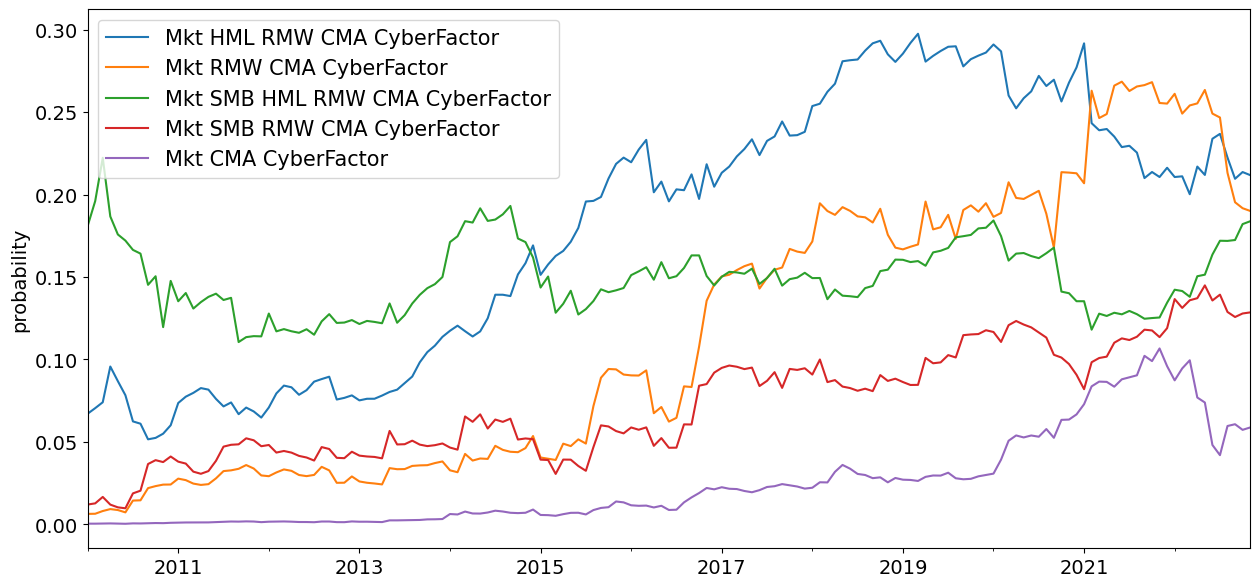

In [8]:
#plot the probabilities
probas_df = pd.DataFrame(probas, index = end_dates,
                         columns = [' '.join(['Mkt']+factors) for factors in included_factors])
probas_df = probas_df.applymap(float)
probas_df = probas_df.iloc[:,probas_df.iloc[-1].argsort()[::-1]] #sort on last observation
(probas_df.iloc[:,:5]).plot(figsize = (15,7))
#plt.grid(axis = 'y')
#plt.title('Model Probabilities', fontsize = 18)
plt.ylabel('probability', fontsize = 14)
plt.legend(fontsize = 15) # bbox_to_anchor = (1,1)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

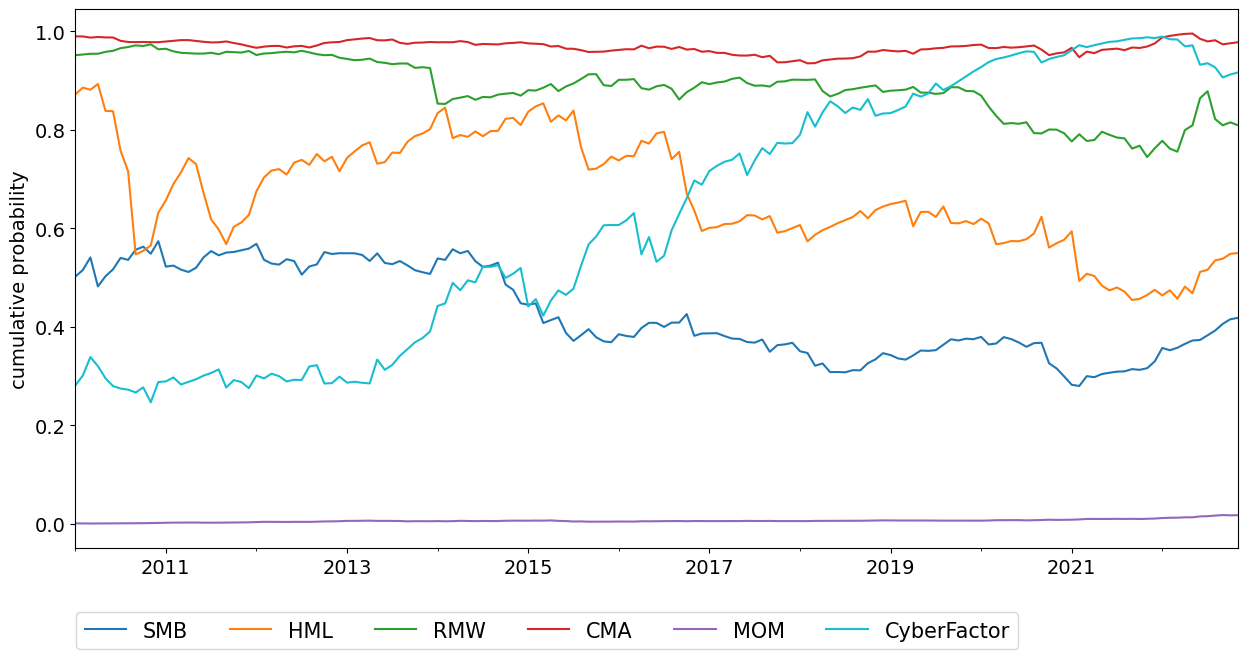

In [152]:
#plot the cumulative factor probabilities
unique_factors = FF5.drop(['RF','Mkt-RF'], axis = 1).columns.values.tolist()

#group columns by factor
grouped_columns = {}
for factor in unique_factors:
    grouped_columns[factor] = [col for col in probas_df.columns if factor in col]

#cumulative proba = sum of probas over models that contain the factor
cum_factor_probas = []
for factor, columns in grouped_columns.items():
    cum_factor_probas.append(probas_df.loc[:,columns].sum(1))
cum_factor_probas = pd.concat(cum_factor_probas, axis = 1)
unique_factors = ['MOM' if factor == 'UMD' else factor for factor in unique_factors]
cum_factor_probas.columns = unique_factors

cum_factor_probas.plot(figsize = (15,7), color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf'])
#plt.title('Cumulative Factor Probabilities')
plt.ylabel('cumulative probability', fontsize = 14)
#plt.grid(axis = 'y')
plt.legend( fontsize = 15,bbox_to_anchor = (0.82,-0.1), ncol = 6) # loc = 'lower left',
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [15]:
#show the cumulative factor probabilities based on the whole sample
cum_factor_probas.iloc[-1,:]

SMB            0.418456
HML            0.550138
RMW            0.809743
CMA            0.977991
UMD            0.017749
CyberFactor    0.916574
Name: 2022-11-01 00:00:00, dtype: float64

In [16]:
#Show the posterior probabilities based on the whole sample
probas_df.iloc[-1,:5]

Mkt HML RMW CMA CyberFactor        0.211805
Mkt RMW CMA CyberFactor            0.190087
Mkt SMB HML RMW CMA CyberFactor    0.183807
Mkt SMB RMW CMA CyberFactor        0.128531
Mkt CMA CyberFactor                0.058738
Name: 2022-11-01 00:00:00, dtype: float64

In [17]:
# Compare the in sample max Sharpe Ratio for the top ranked model and the multpiple to the prior
#Mkt Sharpe Ratio
Mkt = FF5.loc[:,['Mkt-RF']]
Sh2_mkt = Mkt.mean() @ np.linalg.inv(Mkt.cov()) @ Mkt.mean()
print(f'Market Sharpe ratio: {np.sqrt(Sh2_mkt)}')
print('\n')

#Top model sharpe and multiple
f = FF5.loc[:,['Mkt-RF', 'HML', 'RMW', 'CMA', 'CyberFactor']]
Sh2_model = f.mean() @ np.linalg.inv(f.cov()) @ f.mean()
print(f'Top model max Sharpe ratio: {np.sqrt(Sh2_model)}')
print(f'Muliple: {np.sqrt(Sh2_model)/np.sqrt(Sh2_mkt)}')
print('\n')

#Max sharpe and multiple
shs = []
for j in range(len(included_factors)):
    f = FF5.loc[:,['Mkt-RF']+included_factors[j]]
    Sh2_model = f.mean() @ np.linalg.inv(f.cov()) @ f.mean()
    shs.append(np.sqrt(Sh2_model))
argmax = np.argmax(shs)
print(f'Max Sharpe ratio: {np.sqrt(shs[argmax])} for model {" ".join(["Mkt"]+included_factors[argmax])}')
print(f'Multiple: {np.sqrt(shs[argmax])/np.sqrt(Sh2_mkt)}')

Market Sharpe ratio: 0.24843201124600528


Top model max Sharpe ratio: 0.4006482038164319
Muliple: 1.612707645069529


Max Sharpe ratio: 0.6331305327779813 for model Mkt HML RMW CMA UMD CyberFactor
Multiple: 2.548506247655159


### $Sh_{max}$ = 1.25 $Sh_{mkt}$

In [309]:
st_date = '01-01-2009'
end_dates = pd.date_range(start = '01-01-2010', end = '12-01-2022', freq = 'MS', inclusive = 'left')

probas = []
MLs = [] 
for i in tqdm(range(len(end_dates)), display = 'Computing probabilities', leave = False):
    ML = []
    for j in range(len(included_factors)):
        #MLu(f, Mkt)
        # estimate GRS 
        f = FF5.loc[st_date:end_dates[i],included_factors[j]]#st_dates[i]
        Mkt = FF5.loc[st_date:end_dates[i],['Mkt-RF']]
        res_ = LinearRegression().fit(Mkt, f)
        alphas = res_.intercept_
        residuals_ = f.sub(res_.predict(Mkt))
        g, *_ = GRS(alphas, residuals_, Mkt, for_barillas = True)

        T = f.shape[0] # number of time-series observations
        N = f.shape[1] # number of endogenous factors
        K = Mkt.shape[1] # number of exogenous factors

        S = residuals_.T @ residuals_ # cross-product matrix of residuals ~ sum of squared residuals
        FF = (Mkt.T @ Mkt).iat[0,0]
        Sh2_mkt = Mkt.mean() @ np.linalg.inv(Mkt.cov()) @ Mkt.mean()
        Sh2_max = Sh2_mkt*1.25**2 # by assumption
        a = (1 + Sh2_mkt)/T
        k = (Sh2_max-Sh2_mkt)/N
        Q = (1+a/(a+k)*g)**(-(T-K)/2) * (1+k/a)**(-N/2)
        MLu = Decimal(np.abs(FF))**Decimal(-N/2) * \
              Decimal(np.abs(np.linalg.det(S)))**Decimal(-(T-K)/2) * Decimal(Q) 

        #MLr   ## WHAT IF NO EXCLUDED FACTORS?
        Mkt_f = FF5.loc[st_date:end_dates[i],['Mkt-RF']+included_factors[j]]
        f_star = FF5.loc[st_date:end_dates[i],excluded_factors[j]]
        res = LinearRegression(fit_intercept = False).fit(Mkt_f, f_star) #restricted
        residuals = f_star.sub(res.predict(Mkt_f))

        T = f_star.shape[0] # number of time-series observations
        N = f_star.shape[1] # number of endogenous factors
        K = Mkt_f.shape[1] # number of exogenous factors

        Sr = residuals.T @ residuals # cross-product matrix of residuals
        FFr = Mkt_f.T @ Mkt_f
        MLr = Decimal(np.abs(np.linalg.det(FFr)))**Decimal(-N/2) * \
              Decimal(np.abs(np.linalg.det(Sr)))**Decimal(-(T-K)/2)
        
        ML.append(MLu*MLr)

    #uniform prior model probabilities
    probas.append([ml/sum(ML) for ml in ML])
    
clear_output()

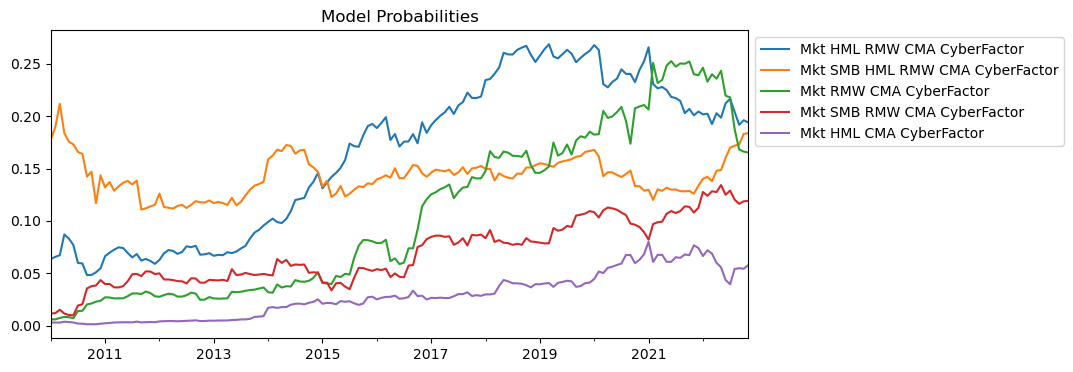

In [310]:
#plot the probabilities
probas_df = pd.DataFrame(probas, index = end_dates,
                         columns = [' '.join(['Mkt']+factors) for factors in included_factors])
probas_df = probas_df.applymap(float)
probas_df = probas_df.iloc[:,probas_df.iloc[-1].argsort()[::-1]] #sort on last observation
(probas_df.iloc[:,:5]).plot(figsize = (9,4))
plt.title('Model Probabilities')
plt.legend(bbox_to_anchor = (1,1))
plt.show()

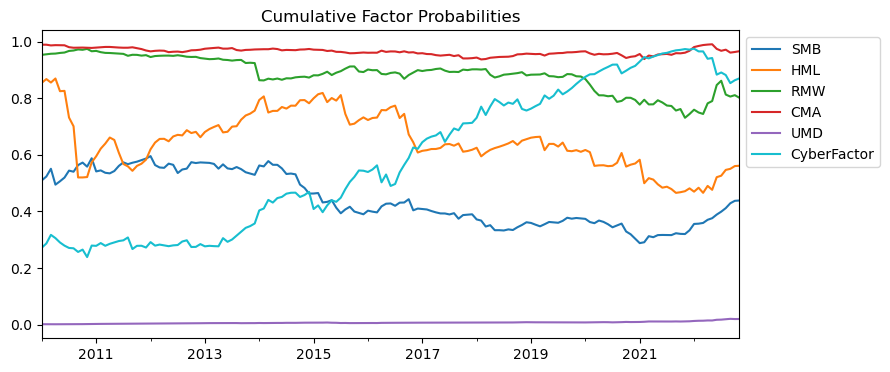

In [311]:
#plot the cumulative factor probabilities
unique_factors = FF5.drop(['RF','Mkt-RF'], axis = 1).columns.values.tolist()

#group columns by factor
grouped_columns = {}
for factor in unique_factors:
    grouped_columns[factor] = [col for col in probas_df.columns if factor in col]

#cumulative proba = sum of probas over models that contain the factor
cum_factor_probas = []
for factor, columns in grouped_columns.items():
    cum_factor_probas.append(probas_df.loc[:,columns].sum(1))
cum_factor_probas = pd.concat(cum_factor_probas, axis = 1)
cum_factor_probas.columns = unique_factors

cum_factor_probas.plot(figsize = (9,4), color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf'])
plt.title('Cumulative Factor Probabilities')
plt.legend(bbox_to_anchor = (1,1))
plt.show()

In [312]:
#Show the posterior probabilities based on the whole sample
probas_df.iloc[-1,:5]

Mkt HML RMW CMA CyberFactor        0.194030
Mkt SMB HML RMW CMA CyberFactor    0.183820
Mkt RMW CMA CyberFactor            0.165389
Mkt SMB RMW CMA CyberFactor        0.119158
Mkt HML CMA CyberFactor            0.057652
Name: 2022-11-01 00:00:00, dtype: float64

### $Sh_{max}$ = 2 $Sh_{mkt}$

In [317]:
st_date = '01-01-2009'
end_dates = pd.date_range(start = '01-01-2010', end = '12-01-2022', freq = 'MS', inclusive = 'left')

probas = []
MLs = [] 
for i in tqdm(range(len(end_dates)), display = 'Computing probabilities', leave = False):
    ML = []
    for j in range(len(included_factors)):
        #MLu(f, Mkt)
        # estimate GRS 
        f = FF5.loc[st_date:end_dates[i],included_factors[j]]#st_dates[i]
        Mkt = FF5.loc[st_date:end_dates[i],['Mkt-RF']]
        res_ = LinearRegression().fit(Mkt, f)
        alphas = res_.intercept_
        residuals_ = f.sub(res_.predict(Mkt))
        g, *_ = GRS(alphas, residuals_, Mkt, for_barillas = True)

        T = f.shape[0] # number of time-series observations
        N = f.shape[1] # number of endogenous factors
        K = Mkt.shape[1] # number of exogenous factors

        S = residuals_.T @ residuals_ # cross-product matrix of residuals ~ sum of squared residuals
        FF = (Mkt.T @ Mkt).iat[0,0]
        Sh2_mkt = Mkt.mean() @ np.linalg.inv(Mkt.cov()) @ Mkt.mean()
        Sh2_max = Sh2_mkt*2**2 # by assumption
        a = (1 + Sh2_mkt)/T
        k = (Sh2_max-Sh2_mkt)/N
        Q = (1+a/(a+k)*g)**(-(T-K)/2) * (1+k/a)**(-N/2)
        MLu = Decimal(np.abs(FF))**Decimal(-N/2) * \
              Decimal(np.abs(np.linalg.det(S)))**Decimal(-(T-K)/2) * Decimal(Q) 

        #MLr   ## WHAT IF NO EXCLUDED FACTORS?
        Mkt_f = FF5.loc[st_date:end_dates[i],['Mkt-RF']+included_factors[j]]
        f_star = FF5.loc[st_date:end_dates[i],excluded_factors[j]]
        res = LinearRegression(fit_intercept = False).fit(Mkt_f, f_star) #restricted
        residuals = f_star.sub(res.predict(Mkt_f))

        T = f_star.shape[0] # number of time-series observations
        N = f_star.shape[1] # number of endogenous factors
        K = Mkt_f.shape[1] # number of exogenous factors

        Sr = residuals.T @ residuals # cross-product matrix of residuals
        FFr = Mkt_f.T @ Mkt_f
        MLr = Decimal(np.abs(np.linalg.det(FFr)))**Decimal(-N/2) * \
              Decimal(np.abs(np.linalg.det(Sr)))**Decimal(-(T-K)/2)
        
        ML.append(MLu*MLr)

    #uniform prior model probabilities
    probas.append([ml/sum(ML) for ml in ML])
    
clear_output()

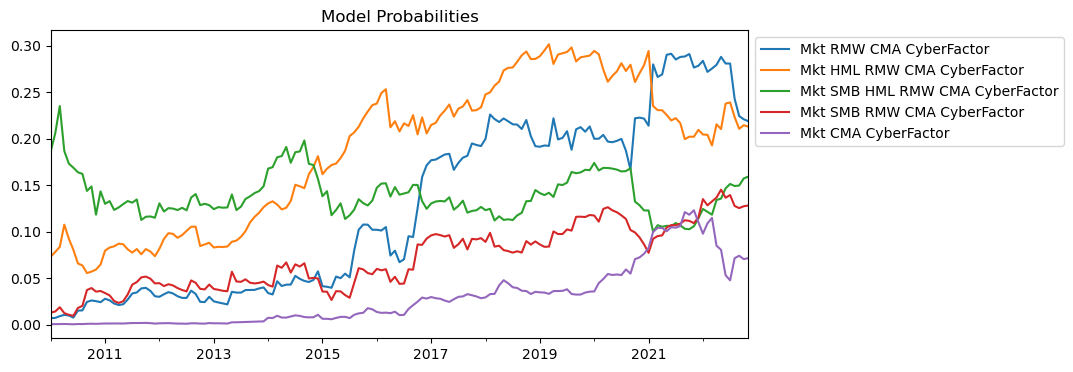

In [318]:
#plot the probabilities
probas_df = pd.DataFrame(probas, index = end_dates,
                         columns = [' '.join(['Mkt']+factors) for factors in included_factors])
probas_df = probas_df.applymap(float)
probas_df = probas_df.iloc[:,probas_df.iloc[-1].argsort()[::-1]] #sort on last observation
(probas_df.iloc[:,:5]).plot(figsize = (9,4))
plt.title('Model Probabilities')
plt.legend(bbox_to_anchor = (1,1))
plt.show()

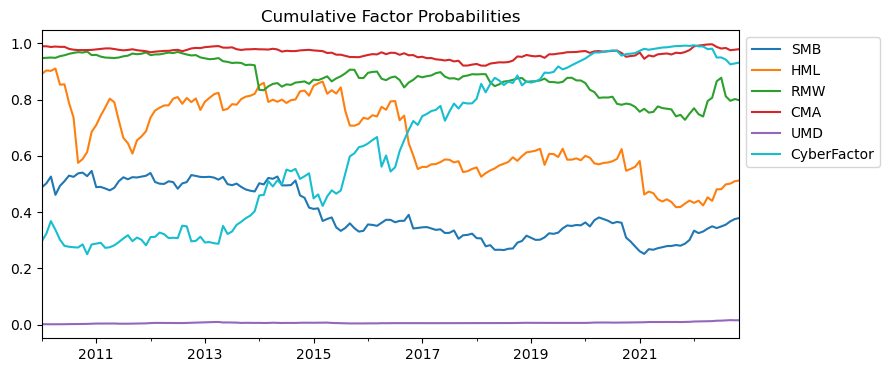

In [319]:
#plot the cumulative factor probabilities
unique_factors = FF5.drop(['RF','Mkt-RF'], axis = 1).columns.values.tolist()

#group columns by factor
grouped_columns = {}
for factor in unique_factors:
    grouped_columns[factor] = [col for col in probas_df.columns if factor in col]

#cumulative proba = sum of probas over models that contain the factor
cum_factor_probas = []
for factor, columns in grouped_columns.items():
    cum_factor_probas.append(probas_df.loc[:,columns].sum(1))
cum_factor_probas = pd.concat(cum_factor_probas, axis = 1)
cum_factor_probas.columns = unique_factors

cum_factor_probas.plot(figsize = (9,4), color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf'])
plt.title('Cumulative Factor Probabilities')
plt.legend(bbox_to_anchor = (1,1))
plt.show()

In [320]:
#Show the posterior probabilities based on the whole sample
probas_df.iloc[-1,:5]

Mkt RMW CMA CyberFactor            0.218905
Mkt HML RMW CMA CyberFactor        0.213067
Mkt SMB HML RMW CMA CyberFactor    0.159224
Mkt SMB RMW CMA CyberFactor        0.128149
Mkt CMA CyberFactor                0.071491
Name: 2022-11-01 00:00:00, dtype: float64

### $Sh_{max}$ = 3 $Sh_{mkt}$

In [321]:
st_date = '01-01-2009'
end_dates = pd.date_range(start = '01-01-2010', end = '12-01-2022', freq = 'MS', inclusive = 'left')

probas = []
MLs = [] 
for i in tqdm(range(len(end_dates)), display = 'Computing probabilities', leave = False):
    ML = []
    for j in range(len(included_factors)):
        #MLu(f, Mkt)
        # estimate GRS 
        f = FF5.loc[st_date:end_dates[i],included_factors[j]]#st_dates[i]
        Mkt = FF5.loc[st_date:end_dates[i],['Mkt-RF']]
        res_ = LinearRegression().fit(Mkt, f)
        alphas = res_.intercept_
        residuals_ = f.sub(res_.predict(Mkt))
        g, *_ = GRS(alphas, residuals_, Mkt, for_barillas = True)

        T = f.shape[0] # number of time-series observations
        N = f.shape[1] # number of endogenous factors
        K = Mkt.shape[1] # number of exogenous factors

        S = residuals_.T @ residuals_ # cross-product matrix of residuals ~ sum of squared residuals
        FF = (Mkt.T @ Mkt).iat[0,0]
        Sh2_mkt = Mkt.mean() @ np.linalg.inv(Mkt.cov()) @ Mkt.mean()
        Sh2_max = Sh2_mkt*3**2 # by assumption
        a = (1 + Sh2_mkt)/T
        k = (Sh2_max-Sh2_mkt)/N
        Q = (1+a/(a+k)*g)**(-(T-K)/2) * (1+k/a)**(-N/2)
        MLu = Decimal(np.abs(FF))**Decimal(-N/2) * \
              Decimal(np.abs(np.linalg.det(S)))**Decimal(-(T-K)/2) * Decimal(Q) 

        #MLr   ## WHAT IF NO EXCLUDED FACTORS?
        Mkt_f = FF5.loc[st_date:end_dates[i],['Mkt-RF']+included_factors[j]]
        f_star = FF5.loc[st_date:end_dates[i],excluded_factors[j]]
        res = LinearRegression(fit_intercept = False).fit(Mkt_f, f_star) #restricted
        residuals = f_star.sub(res.predict(Mkt_f))

        T = f_star.shape[0] # number of time-series observations
        N = f_star.shape[1] # number of endogenous factors
        K = Mkt_f.shape[1] # number of exogenous factors

        Sr = residuals.T @ residuals # cross-product matrix of residuals
        FFr = Mkt_f.T @ Mkt_f
        MLr = Decimal(np.abs(np.linalg.det(FFr)))**Decimal(-N/2) * \
              Decimal(np.abs(np.linalg.det(Sr)))**Decimal(-(T-K)/2)
        
        ML.append(MLu*MLr)

    #uniform prior model probabilities
    probas.append([ml/sum(ML) for ml in ML])
    
clear_output()

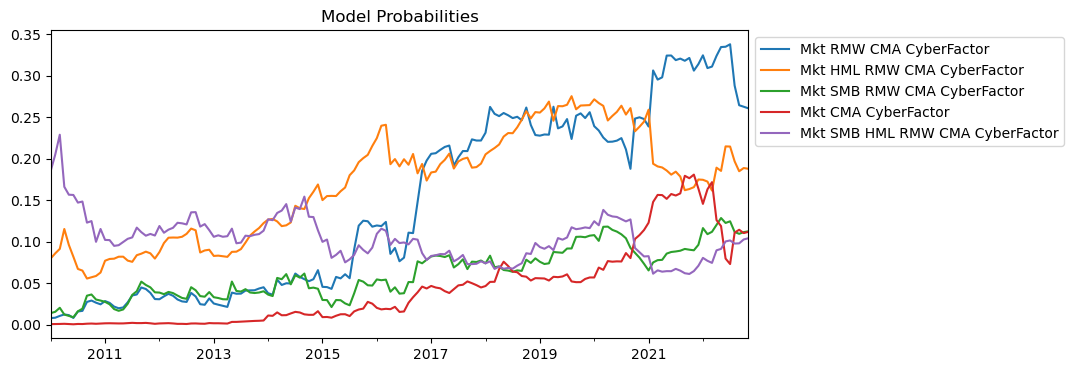

In [322]:
#plot the probabilities
probas_df = pd.DataFrame(probas, index = end_dates,
                         columns = [' '.join(['Mkt']+factors) for factors in included_factors])
probas_df = probas_df.applymap(float)
probas_df = probas_df.iloc[:,probas_df.iloc[-1].argsort()[::-1]] #sort on last observation
(probas_df.iloc[:,:5]).plot(figsize = (9,4))
plt.title('Model Probabilities')
plt.legend(bbox_to_anchor = (1,1))
plt.show()

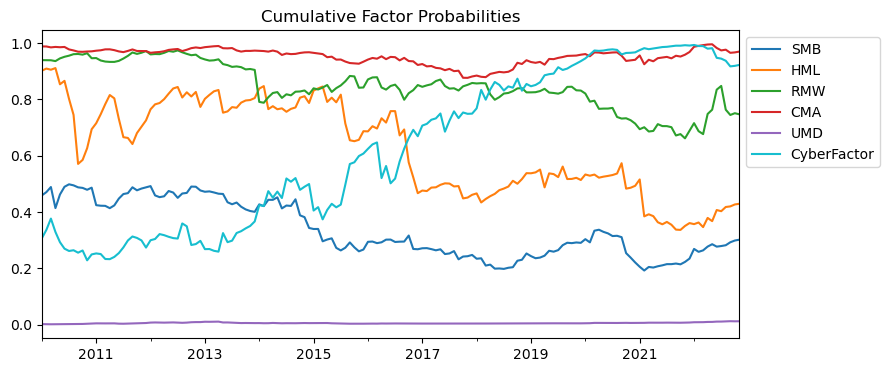

In [323]:
#plot the cumulative factor probabilities
unique_factors = FF5.drop(['RF','Mkt-RF'], axis = 1).columns.values.tolist()

#group columns by factor
grouped_columns = {}
for factor in unique_factors:
    grouped_columns[factor] = [col for col in probas_df.columns if factor in col]

#cumulative proba = sum of probas over models that contain the factor
cum_factor_probas = []
for factor, columns in grouped_columns.items():
    cum_factor_probas.append(probas_df.loc[:,columns].sum(1))
cum_factor_probas = pd.concat(cum_factor_probas, axis = 1)
cum_factor_probas.columns = unique_factors

cum_factor_probas.plot(figsize = (9,4), color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf'])
plt.title('Cumulative Factor Probabilities')
plt.legend(bbox_to_anchor = (1,1))
plt.show()

In [324]:
#Show the posterior probabilities based on the whole sample
probas_df.iloc[-1,:5]

Mkt RMW CMA CyberFactor            0.260832
Mkt HML RMW CMA CyberFactor        0.187917
Mkt SMB RMW CMA CyberFactor        0.112444
Mkt CMA CyberFactor                0.111823
Mkt SMB HML RMW CMA CyberFactor    0.104127
Name: 2022-11-01 00:00:00, dtype: float64

### $Sh_{max}$ = 4 $Sh_{mkt}$

In [18]:
st_date = '01-01-2009'
end_dates = pd.date_range(start = '01-01-2010', end = '12-01-2022', freq = 'MS', inclusive = 'left')

probas = []
MLs = [] 
for i in tqdm(range(len(end_dates)), display = 'Computing probabilities', leave = False):
    ML = []
    for j in range(len(included_factors)):
        #MLu(f, Mkt)
        # estimate GRS 
        f = FF5.loc[st_date:end_dates[i],included_factors[j]]#st_dates[i]
        Mkt = FF5.loc[st_date:end_dates[i],['Mkt-RF']]
        res_ = LinearRegression().fit(Mkt, f)
        alphas = res_.intercept_
        residuals_ = f.sub(res_.predict(Mkt))
        g, *_ = GRS(alphas, residuals_, Mkt, for_barillas = True)

        T = f.shape[0] # number of time-series observations
        N = f.shape[1] # number of endogenous factors
        K = Mkt.shape[1] # number of exogenous factors

        S = residuals_.T @ residuals_ # cross-product matrix of residuals ~ sum of squared residuals
        FF = (Mkt.T @ Mkt).iat[0,0]
        Sh2_mkt = Mkt.mean() @ np.linalg.inv(Mkt.cov()) @ Mkt.mean()
        Sh2_max = Sh2_mkt*(4**2) # by assumption
        a = (1 + Sh2_mkt)/T
        k = (Sh2_max-Sh2_mkt)/N
        Q = (1+a/(a+k)*g)**(-(T-K)/2) * (1+k/a)**(-N/2)
        MLu = Decimal(np.abs(FF))**Decimal(-N/2) * \
              Decimal(np.abs(np.linalg.det(S)))**Decimal(-(T-K)/2) * Decimal(Q) 

        #MLr   ## WHAT IF NO EXCLUDED FACTORS?
        Mkt_f = FF5.loc[st_date:end_dates[i],['Mkt-RF']+included_factors[j]]
        f_star = FF5.loc[st_date:end_dates[i],excluded_factors[j]]
        res = LinearRegression(fit_intercept = False).fit(Mkt_f, f_star) #restricted
        residuals = f_star.sub(res.predict(Mkt_f))

        T = f_star.shape[0] # number of time-series observations
        N = f_star.shape[1] # number of endogenous factors
        K = Mkt_f.shape[1] # number of exogenous factors

        Sr = residuals.T @ residuals # cross-product matrix of residuals
        FFr = Mkt_f.T @ Mkt_f
        MLr = Decimal(np.abs(np.linalg.det(FFr)))**Decimal(-N/2) * \
              Decimal(np.abs(np.linalg.det(Sr)))**Decimal(-(T-K)/2)
        
        ML.append(MLu*MLr)

    #uniform prior model probabilities
    probas.append([ml/sum(ML) for ml in ML])
    
clear_output()

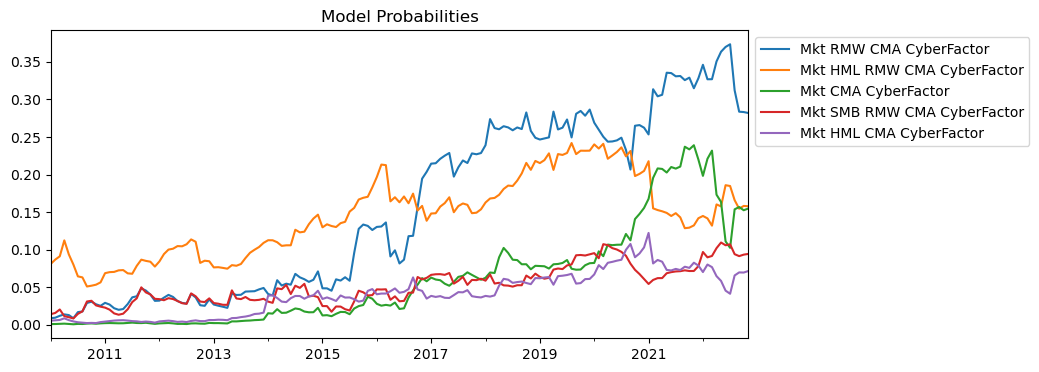

In [19]:
#plot the probabilities
probas_df = pd.DataFrame(probas, index = end_dates,
                         columns = [' '.join(['Mkt']+factors) for factors in included_factors])
probas_df = probas_df.applymap(float)
probas_df = probas_df.iloc[:,probas_df.iloc[-1].argsort()[::-1]] #sort on last observation
(probas_df.iloc[:,:5]).plot(figsize = (9,4))
plt.title('Model Probabilities')
plt.legend(bbox_to_anchor = (1,1))
plt.show()

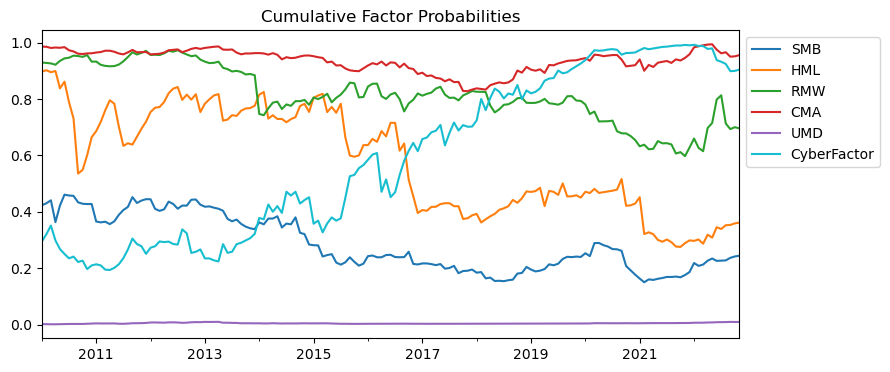

In [20]:
#plot the cumulative factor probabilities
unique_factors = FF5.drop(['RF','Mkt-RF'], axis = 1).columns.values.tolist()

#group columns by factor
grouped_columns = {}
for factor in unique_factors:
    grouped_columns[factor] = [col for col in probas_df.columns if factor in col]

#cumulative proba = sum of probas over models that contain the factor
cum_factor_probas = []
for factor, columns in grouped_columns.items():
    cum_factor_probas.append(probas_df.loc[:,columns].sum(1))
cum_factor_probas = pd.concat(cum_factor_probas, axis = 1)
cum_factor_probas.columns = unique_factors

cum_factor_probas.plot(figsize = (9,4), color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf'])
plt.title('Cumulative Factor Probabilities')
plt.legend(bbox_to_anchor = (1,1))
plt.show()

In [21]:
#Show the posterior probabilities based on the whole sample
probas_df.iloc[-1,:5]

Mkt RMW CMA CyberFactor        0.281954
Mkt HML RMW CMA CyberFactor    0.157758
Mkt CMA CyberFactor            0.154664
Mkt SMB RMW CMA CyberFactor    0.094246
Mkt HML CMA CyberFactor        0.071441
Name: 2022-11-01 00:00:00, dtype: float64

## Factor correlations

In [80]:
#Factor returns
FF5 = pd.read_csv('../data/FF_factors/FF5.csv',skiprows = 3, index_col = 0)[:714].astype(float)
FF5 = FF5/100 # in percent?????
FF5.index.rename('date', inplace = True)
FF5.index = pd.to_datetime(FF5.index, format = '%Y%m')
momentum = pd.read_csv('../data/FF_factors/Momentum.csv',skiprows = 13, index_col = 0)[:1153].astype(float)
momentum = momentum/100 # in percent?????
momentum.index.rename('date', inplace = True)
momentum.index = pd.to_datetime(momentum.index, format = '%Y%m')
momentum.columns = ['UMD']
FF5 = FF5.merge(momentum,left_index = True,right_index = True)
#add the CyberFactor
CyberFactor = pd.read_csv('../data/cyber_risk_measures/doc2vec/CyberFactor.csv.gz', index_col = 0)
CyberFactor.index = pd.to_datetime(CyberFactor.index)
FF5 = pd.concat([FF5, CyberFactor],axis =1, join = 'inner')

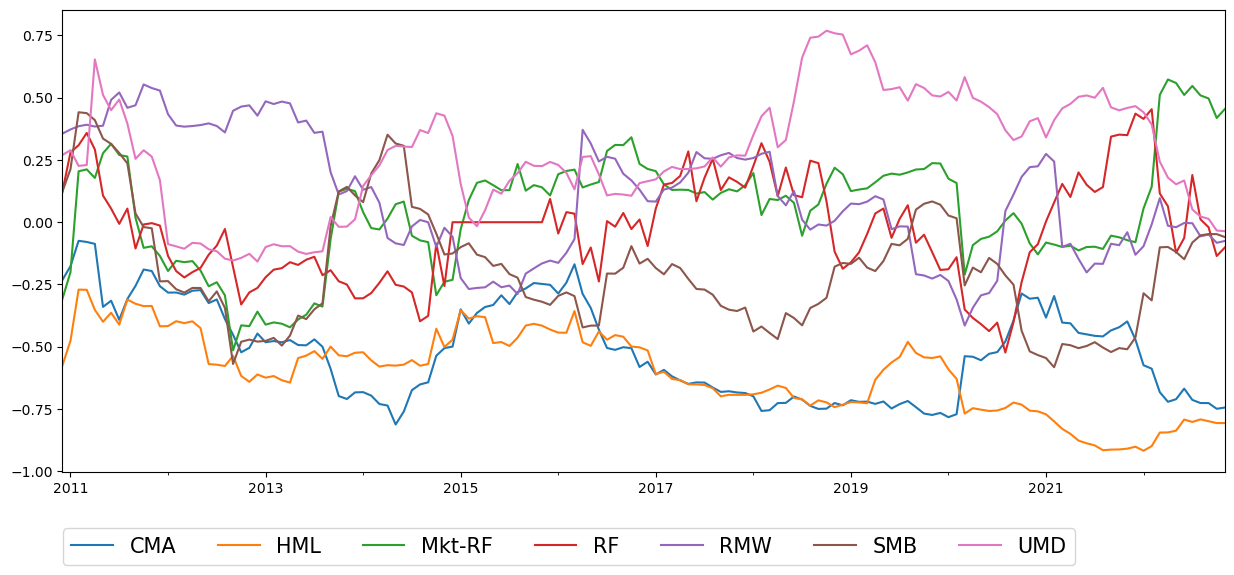

In [49]:
FF5.rolling(24).corr().dropna().CyberFactor.unstack().drop(columns = 'CyberFactor').plot(figsize = (15,6))
plt.legend( fontsize = 15,bbox_to_anchor = (0.88,-0.1), ncol = 7)
plt.show()

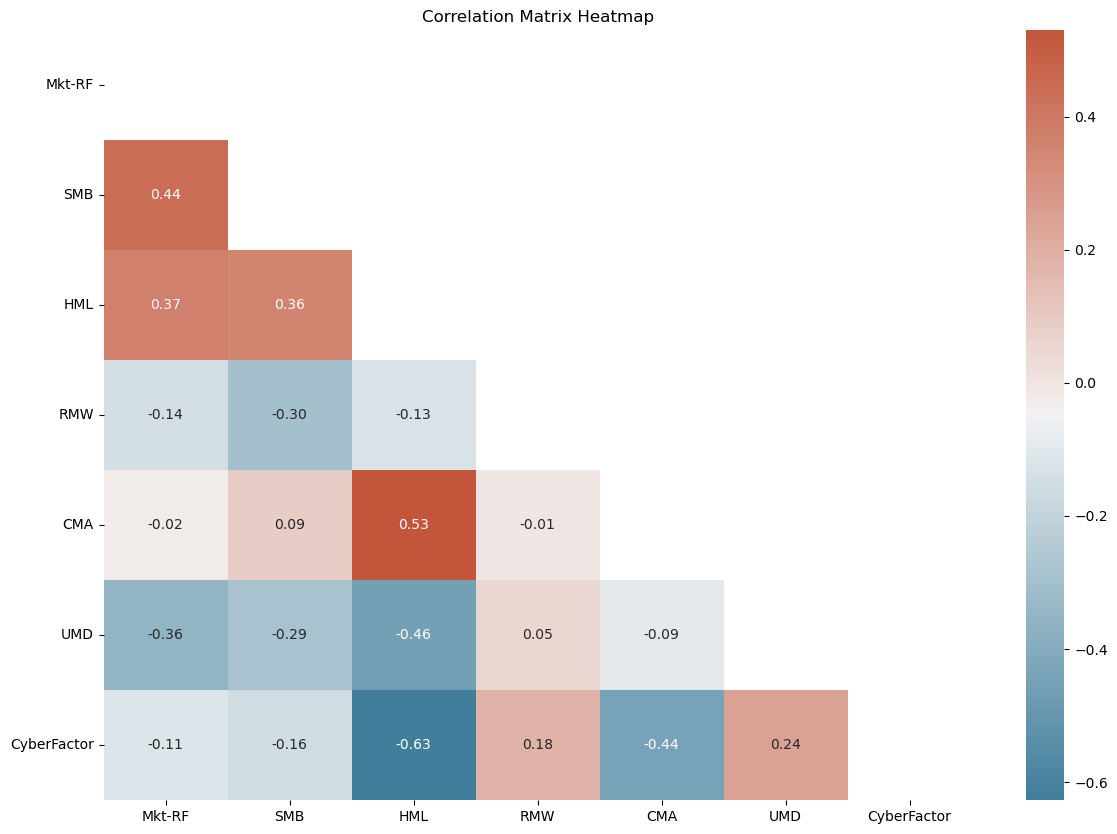

In [27]:
# Calculate the correlation matrix
correlation_matrix = FF5[FF5.index< '2020-10-01'].drop(columns = ['RF']).corr()

# Create a heatmap using seaborn
plt.figure(figsize=(14, 10))  
#Generate a mask for upper traingle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
#color map
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, mask = mask, fmt = '.2f')
plt.yticks(rotation=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

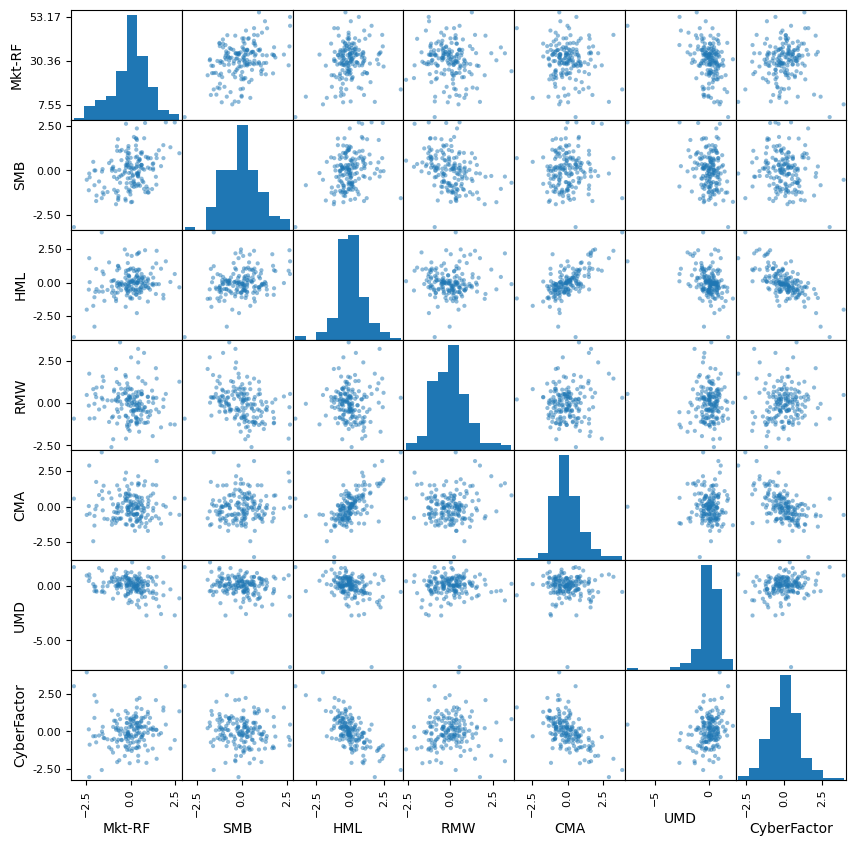

In [75]:
scaler = StandardScaler()
temp = FF5.drop(columns = ['RF'])
temp = pd.DataFrame(scaler.fit_transform(temp), columns=temp.columns,
                               index = temp.index)
axes = pd.plotting.scatter_matrix(temp, figsize = (10,10), alpha = 0.5)
for ax in axes.flatten():
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 
plt.show()

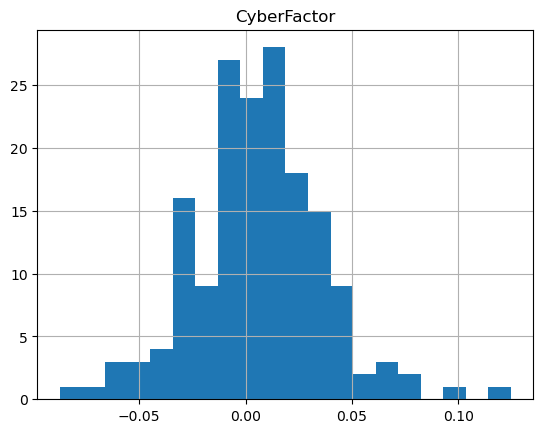

Mean return = 0.556%
Std of returns = 3.055%
Skew of returns = 0.26
Kurtosis of returns = 1.47


In [92]:
CyberFactor.hist(bins = 20)
plt.show()

print(f'Mean return = {np.mean(CyberFactor.values):.3%}')
print(f'Std of returns = {np.std(CyberFactor.values):.3%}')
print(f'Skew of returns = {skew(CyberFactor.values)[0]:.2}')
print(f'Kurtosis of returns = {kurtosis(CyberFactor.values)[0]:.3}')

## Stock return stats

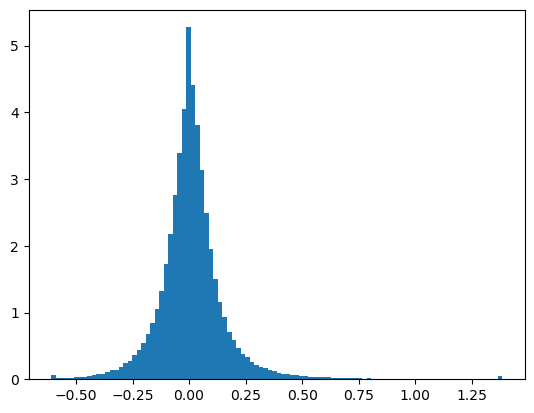

Mean return = 1.118%
Std of returns = 15.455%
Skew of returns = 1.8
Kurtosis of returns = 13.3


In [39]:
#read in the stock returns
read_path = '../data/returns/'
returns = pd.read_csv(read_path+'monthly_returns.csv.gz', index_col = 'date')
returns.index = pd.to_datetime(returns.index)
temp = returns.values.flatten()
temp = temp[~np.isnan(temp)]

from scipy.stats.mstats import winsorize
from scipy.stats import skew, kurtosis
winsorized_temp = winsorize(temp, limits=(0.001, 0.001))

plt.hist(winsorized_temp, bins = 100, density = True)
plt.show()

print(f'Mean return = {np.mean(winsorized_temp):.3%}')
print(f'Std of returns = {np.std(winsorized_temp):.3%}')
print(f'Skew of returns = {skew(winsorized_temp):.2}')
print(f'Kurtosis of returns = {kurtosis(winsorized_temp):.3}')

In [93]:
#read in the general cybersecurity measure
cyber_measures_path = '../data/cyber_risk_measures/doc2vec/'
general_cybersec = pd.read_csv(cyber_measures_path+'general_cybersec_scores.csv.gz', index_col = 0)

In [112]:
# Create an empty dataframe to store results
top_companies_df = pd.DataFrame(index=general_cybersec.index, columns = ['1st','2nd','3rd','4th','5th'])

# Loop through years
for year in general_cybersec.index:
    # Get the top 5 companies for the current year
    top_5_companies = general_cybersec.loc[year].nlargest(5).index
    
    # Store the top companies in the result dataframe
    top_companies_df.loc[year] = top_5_companies

In [113]:
top_companies_df

,1st,2nd,3rd,4th,5th
2008,OSPN,IPAS,SCUR,APKT,WYY
2009,GSB,APKT,IPAS,VHC,DLB
2010,GSB,ORGS,VRSN,APKT,DLB
2011,ORGS,GSB,WBSN,OSPN,CYDE
2012,WBSN,GSB,OSPN,ZIXI,VMW
2013,WBSN,FIRE,GSB,FVRL,PFPT
2014,TWTR,OSPN,ZIXI,SPLK,RHT
2015,AWRE,SPLK,CTXS,TWTR,OSPN
2016,AWRE,RHT,IMPV,GSB,TWTR
2017,FTNT,TWTR,RHT,PANW,VRME


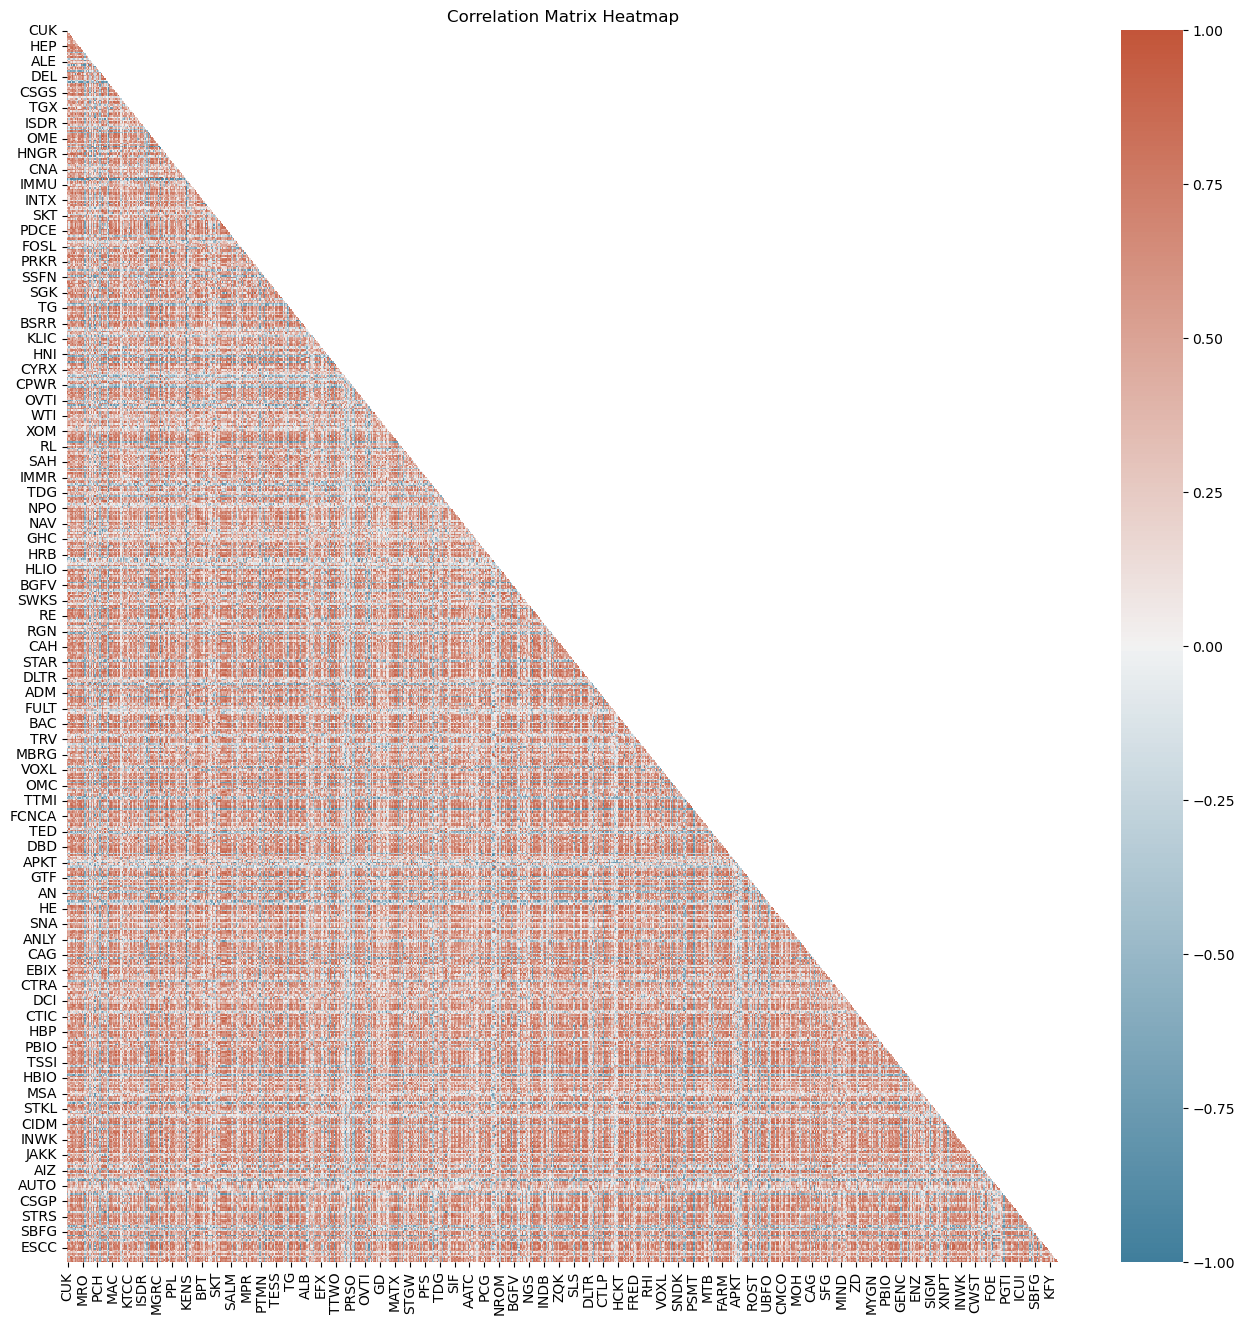

In [68]:
correlation_matrix = general_cybersec.loc[:,(~general_cybersec.isnull()).sum() > 5].iloc[:,:800].corr()

# Create a heatmap using seaborn
plt.figure(figsize=(16, 16))  
#Generate a mask for upper traingle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
#color map
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_matrix, annot=False, cmap=cmap, mask = mask, fmt = '.2f')
plt.yticks(rotation=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

<AxesSubplot:>

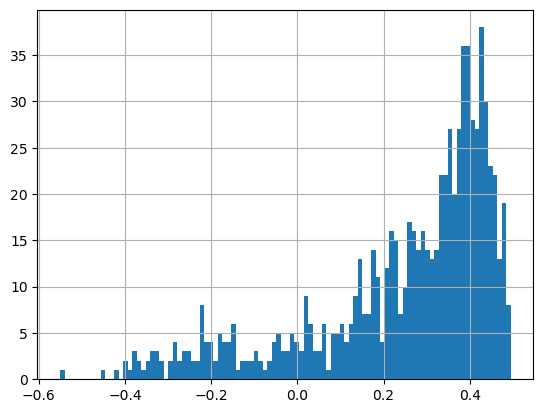

In [76]:
correlation_matrix.mean().hist(bins = 100)

## Within industry portfolio sorts

In [590]:
#read in the necessary files (firm characteristics)
read_path = '../data/returns/'
book_value = pd.read_csv(read_path + 'book_values.csv.gz', index_col = 'date')
book_to_market = pd.read_csv(read_path+'book_to_market.csv.gz', index_col = 'date')
total_assets = pd.read_csv(read_path + 'firm_sizes.csv.gz', index_col = 'date')
ROA = pd.read_csv(read_path+'ROA.csv.gz', index_col = 'date')
firm_age = pd.read_csv(read_path+'firm_ages.csv.gz', index_col = 'date')
TobinQ = pd.read_csv(read_path+'TobinsQ.csv.gz', index_col = 'date')
betas = pd.read_csv(read_path+'mkt_betas.csv.gz', index_col = 'date')
intangibles_to_assets = pd.read_csv(read_path+'intangibles_to_assets.csv.gz',index_col = 'date')
returns = pd.read_csv(read_path+'monthly_returns.csv.gz', index_col = 'date')
#read in the previously saved stocknames file
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.replace('', np.nan, inplace = True)
stocknames.FF_Industry_code = stocknames.FF_Industry_code.astype(float)
#read in the general cybersecurity measure
cyber_measures_path = '../data/cyber_risk_measures/doc2vec/'
general_cybersec = pd.read_csv(cyber_measures_path+'general_cybersec_scores.csv.gz', index_col = 0)

book_value.index = pd.to_datetime(book_value.index)
book_to_market.index = pd.to_datetime(book_to_market.index)
total_assets.index = pd.to_datetime(total_assets.index)
ROA.index = pd.to_datetime(ROA.index)
firm_age.index = pd.to_datetime(firm_age.index)
TobinQ.index = pd.to_datetime(TobinQ.index)
betas.index = pd.to_datetime(betas.index)
intangibles_to_assets.index = pd.to_datetime(intangibles_to_assets.index)
returns.index = pd.to_datetime(returns.index)
mkt_caps.index = pd.to_datetime(mkt_caps.index)

#Factor returns
FF5 = pd.read_csv('../data/FF_factors/FF5.csv',skiprows = 3, index_col = 0)[:714].astype(float)
FF5 = FF5/100 # in percent?????
FF5.index.rename('date', inplace = True)
FF5.index = pd.to_datetime(FF5.index, format = '%Y%m')
momentum = pd.read_csv('../data/FF_factors/Momentum.csv',skiprows = 13, index_col = 0)[:1153].astype(float)
momentum = momentum/100 # in percent?????
momentum.index.rename('date', inplace = True)
momentum.index = pd.to_datetime(momentum.index, format = '%Y%m')
momentum.columns = ['UMD']
FF5 = FF5.merge(momentum,left_index = True,right_index = True)

In [591]:
dates = pd.date_range(start = '01-01-2009', end = '12-01-2022', freq = 'MS', inclusive = 'left')
quarters = dates[::3]
ew_low_tercile_returns = []
ew_middle_tercile_returns = []
ew_high_tercile_returns = []
vw_low_tercile_returns = []
vw_middle_tercile_returns = []
vw_high_tercile_returns = []
nb_firms = []
mkt_values = []
book_to_markets = []
ROAs = []
risk_index_quintiles = []

#drop firms with less than 3 years (table 7 caption)
general_cybersec = general_cybersec.loc[:,(~general_cybersec.isnull()).sum()>3]

#drop cyber security firms
general_cybersec = general_cybersec.loc[:,~general_cybersec.columns.isin(cyber_firms)]

firms_in_industry = stocknames[stocknames.FF_Industry_code == 11].ticker.values
general_cybersec = general_cybersec.loc[:, general_cybersec.columns.isin(firms_in_industry)]


ew_ret = {}
vw_ret = {}
for i,month in enumerate(dates):
    #update every quarter
    if(month in quarters):
        #Cyber scores for the year
        Cybersec = general_cybersec.loc[month.year,:].dropna()
        #drop firms with no mkt cap the previous month or no ret the next 4 months
        mkt_caps_ = mkt_caps.loc[dates[i-1],Cybersec.index].dropna()
        Cybersec = Cybersec.loc[mkt_caps_.index]
        try:
            firms_with_ret = returns.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
        except:
            firms_with_ret = returns.loc[month:dates[i+1]].dropna(axis = 1,how = 'any').columns
        mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]
        Cybersec = Cybersec[Cybersec.index.isin(firms_with_ret)]

        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[Cybersec.index.values]
        fd[fd_col] = pd.to_datetime(fd[fd_col])

        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        Cybersec.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        Cybersec.dropna(inplace = True)
        mkt_caps_ = mkt_caps_.loc[mkt_caps_.index.isin(Cybersec.index)]

        #sort firms into quintiles
        quintiles = pd.qcut(Cybersec, q = 5, labels = False)

        quantile_weights = []
        for q in range(5):
            firms = quintiles[quintiles == q].index
            quantile_weights.append(mkt_caps_.loc[firms].div(mkt_caps_.loc[firms].sum()))
            nb_firms.append(len(firms))
    
    ew_ret[month] = []
    vw_ret[month] = []
    for q in range(5):
        firms = quintiles[quintiles == q].index
        quantile_ret = returns.loc[month, firms]
        #equally weighted portfolios
        ew_ret[month].append(quantile_ret.mean())
        #value weighted portfolios
        vw_ret[month].append(quantile_ret.multiply(quantile_weights[q]).sum())
        
        #get current risk index of the portfolio
        cyber = general_cybersec.loc[month.year,firms]
        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[firms]
        fd[fd_col] = pd.to_datetime(fd[fd_col])
        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        cyber.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        risk_index_quintiles.append(cyber.multiply(quantile_weights[q]).sum())

idx = ['quintile_'+str(i) for i in range(5)]
ew_ret = pd.DataFrame(ew_ret, index = idx).T
vw_ret = pd.DataFrame(vw_ret, index = idx).T
risk_index_quintiles = np.reshape(risk_index_quintiles,(-1,5))
nb_firms = np.reshape(nb_firms,(-1,5))

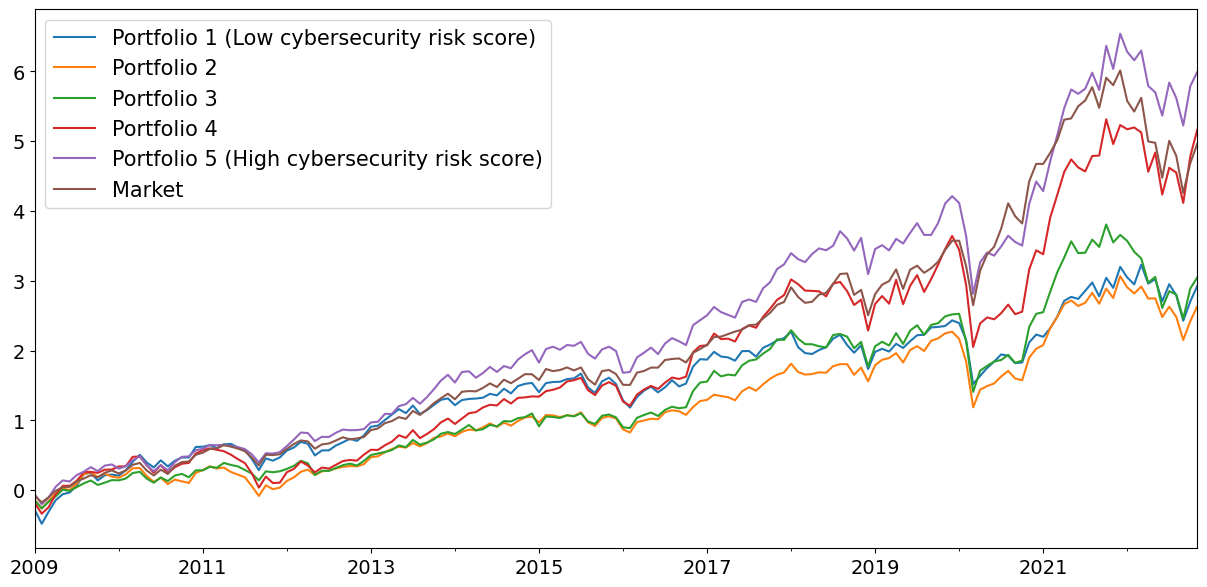

In [592]:
#plot the cumulative return of the quintile portfolios and the market portfolio
Mkt = FF5['Mkt-RF'].add(FF5['RF'])
Mkt.name = 'Mkt'
temp = pd.concat([vw_ret, Mkt[Mkt.index.isin(vw_ret.index)]], axis = 1)
#temp['LS'] = temp.quintile_4.sub(temp.quintile_0)
((temp+1).cumprod()-1).plot(figsize = (15,7))
#plt.title('Cumulative Returns', fontsize = 18)
plt.legend(['Portfolio 1 (Low cybersecurity risk score)', 'Portfolio 2', 'Portfolio 3',
            'Portfolio 4', 'Portfolio 5 (High cybersecurity risk score)',
            'Market'], fontsize = 15)#,'Long Short Portfolio (H-L)'
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [593]:
#value weighted excess returns and alphas
table, pval_table, t_stat_table = get_alphas(vw_ret, FF5)
print('Value weighted portfolios')
display(table.style.format("{:.2%}"))
print('p-values:')
display(pval_table.style.format("{:.3f}"))
print('t stats:')
display(t_stat_table.style.format("{:.3f}"))

#characteristics of the portfolios
tableB = pd.DataFrame(np.ones([2,5]), index = ['Number of firms', 'Cybersecurity risk index'],
                      columns = ['Q1 (low)', 'Q2', 'Q3', 'Q4', 'Q5 (high)'])
tableB.loc['Number of firms',:] = np.mean(nb_firms, axis = 0)
tableB.loc['Cybersecurity risk index',:] = np.mean(risk_index_quintiles, axis = 0)

tableB.style.format("{:.3f}")

Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,1.01%,0.89%,0.95%,1.27%,1.26%,0.25%
CAPM alpha,-0.35%,-0.34%,-0.26%,-0.14%,0.11%,0.46%
FFC alpha,-0.18%,-0.23%,-0.13%,0.07%,0.22%,0.40%
FF5 alpha,0.03%,-0.12%,0.03%,0.26%,0.29%,0.26%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.012,0.007,0.007,0.002,0.000,0.257
CAPM alpha,0.230,0.181,0.193,0.645,0.481,0.081
FFC alpha,0.409,0.144,0.352,0.711,0.047,0.125
FF5 alpha,0.912,0.343,0.762,0.081,0.002,0.320


t stats:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,2.509,2.677,2.708,3.042,4.074,1.133
CAPM alpha,-1.201,-1.338,-1.302,-0.461,0.705,1.745
FFC alpha,-0.825,-1.463,-0.932,0.371,1.988,1.533
FF5 alpha,0.111,-0.947,0.303,1.742,3.071,0.994


,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,140.071,139.482,139.500,139.482,139.857
Cybersecurity risk index,0.488,0.501,0.511,0.521,0.546
